<img src="./../../reports/figures/istockphoto-1141156865-612x612.jpeg" width="800" class="center">

# Inferential Analysis of Real Property Sales in King County in 2019
Author: Chi Bui

------

## Overview

The objective of this project is to use **inferential regression** combined with **hypothesis testing** and **visualization** to identify potential **home improvement project ideas** for homeowners in King County (WA) that will **add to the sale values of their properties**.

## Business Problems

"Expert judgments" by Real Estate professionals are sometimes found to be out-of-date, irrelevant to our specific housing market, or even inaccurate. The purpose of this project is to verify and extend on the below claims:

1. [Enclosing a porch will increase the sale price of a home](https://www.patioenclosures.com/what-is-the-value-of-adding-a-porch-enclosure-to-my-outdoor-space.aspx)
2. [Converting a garage to a bedroom is a good way to increase the sale price of a home](https://www.fool.com/millionacres/real-estate-market/home-renovations/should-you-convert-your-garage-extra-living-space/)
3. [Upgrading to a forced-air heating system will increase the sale price of a home](https://crystalheatingandcooling.com/new-hvac-unit-increase-the-overall-value-of-your-home/)

## Dataset

### Data Understanding

For this project, I have been provided with King County House Sales dataset which included 4 different tables:
1. **Real Property Sales** (`EXTR_RPSale.csv`) (located in the `data/raw` directory)
2. **Residential Building** (`EXTR_ResBldg.csv`) (located in the `data/raw` directory)
3. **Parcel** (`EXTR_Parcel.csv`) (located in the `data/raw` directory)
4. **Look Up** (`EXTR_LookUp.csv`) (located in the `data/raw` directory)
5. `King_County_Home_Sales_Data_Dictionary.pdf` (located in the `references` directory)

In [1]:
# import libraries
import os

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [2]:
# import helper functions
import sys
path_to_src = os.path.join('..', 'src')
sys.path.insert(0, path_to_src)
from helper_module import *

In [3]:
dt_lst = ['EXTR_RPSale.csv', 'EXTR_ResBldg.csv', 'EXTR_Parcel.csv', 'EXTR_LookUp.csv']
dfs = {}

In [4]:
path_to_raw = os.path.join('..', '..', 'data', 'raw')
for f in dt_lst:
    f_key = f[5:-4]
    dfs[f_key] = pd.read_csv(os.path.join(path_to_raw, f), dtype='str')

Upon exploring each table in the dataset, my understanding is that: 
- **Parcel** table has 81 columns and 205199 entries, each of which is a registered extended piece of land with a unique identification number (`PIN`). Each lot's PIN can be obtained by concatenating that parcel's `Major` and `Minor` columns together. The information **Parcel** contains is regarding each parcel/lot's position (Plat, Range, Township), its Area in square footage, its Water & Sewer System, Street Surface, any Restrictions it might have, different Views that can be observed from there, whether there's any type of Noises, or any type of Problems reported about that specific lot, etc.


- **ResBldg** table contains 181510 entries and 50 columns. Each entry is a present/previously registered Residential Property, as well as other information regarding that property, such as Address, number of Stories/Bathrooms/Bedrooms/Fireplaces, the Square Footage of each floor and Basement, Heat System & Heat Source, when it was Built and/or Renovated, its Condition, Grade, as well as any Additional Costs associated with it. Each property also comes with its associated `Major` and `Minor` codes, which indicates the parcel that property is on. Note that there could be multiple properties on a parcel, which means that there could be multiple entries sharing the same `Major` and `Minor`.


- **Real Property Sales** contains 351067 entries and 24 columns. Each entries is a sales transaction documented. Besides the Sale Price, it also has other information about the sale, such as the Date it was documented, Buyer/Seller, Plat, Sale Reason, etc. The unique ID for this dataframe can be obtained by concatenating the `ExciseTaxNbr` with `Major` and `Minor` to create a string of alphanumerical characters. Similar to **ResBldg**, there can be multiple sales transactions on a parcel, and multiple entries sharing the same PIN (`Major` + `Minor`).


- **Look Up** table explains the meaning of numerical codes values in the above tables. For example, Street Surface (`StreetSurface`) attribute in **Parcel** is a number with lookup code 60, which indicates that 1 means `PAVED`, 2 means `GRAVEL`, 3 means `DIRT`, and 4 means `UNDEVELOPED`.


- `King_County_Home_Sales_Data_Dictionary.pdf` file helps matching each attribute to its Look Up code, as well as any other further clarifications on how the data for that attributed is supposed to be entered.

### Data Merging

The detail process on how I chose to merge these dataframes can be found in the `data_cleaning.ipynb` notebook []. 

Basically after investigating the entries with the same `PIN` (`PIN = Major + Minor`) in the **ResBldg** dataset, I noticed that their values for the same attributes are usually the same and/or within the similar range. 

In [5]:
dfs['ResBldg']['PIN'] = dfs['ResBldg'].Major + dfs['ResBldg'].Minor

In [6]:
dfs['ResBldg'][dfs['ResBldg'].PIN == '0114100979']\
              [['Address', 'BldgNbr', 'Stories', 'SqFtTotLiving', 'Bedrooms',
              'BathFullCount', 'SqFtGarageBasement', 'HeatSystem', 'YrBuilt']]

,Address,BldgNbr,Stories,SqFtTotLiving,Bedrooms,BathFullCount,SqFtGarageBasement,HeatSystem,YrBuilt
12243,18254 73RD AVE NE,2,2,1890,3,3,400,5,2019
12244,18254 73RD AVE NE,1,2,1880,3,3,400,7,2019
12245,18254 73RD AVE NE,10,2,1880,3,3,400,7,2019
12246,18254 73RD AVE NE,9,2,1790,3,3,400,7,2019
12247,18254 73RD AVE NE,5,2,1370,2,1,510,7,2019
12248,18254 73RD AVE NE,12,2,1390,2,2,490,7,2019
12249,18254 73RD AVE NE,8,2,1390,2,2,520,7,2019
12250,18254 73RD AVE NE,4,2,1460,2,1,510,7,2019
12251,18254 73RD AVE NE,3,2,1420,2,2,520,7,2019
12252,18254 73RD AVE NE,7,2,1460,2,2,520,7,2019


My understanding is that usually different properties on the same lot can be really close, but don't necessarily have the same Building Number, unless these are different units/apartments in a Condo/Aparment Buildings or some types of Housing complexes. 

Utilizing other resources such as **Google Maps**, as well as Real Estate websites to look up the addresses of these properties (for example, [this](https://goo.gl/maps/otaZZdEygNhSQJot6) is the result of searching for the address `"18254 73RD AVE NE"` on **Google Maps**), I suspect that it's more likely these houses/apartments are part of a complex with very similar exterior as well as interior structure. Therefore, I decided to compact entries with duplicated PIN by keeping only 1 row which retains the modes for each attributes. That way `'PIN'` would become unique, and merging the 2 tables `RPSale` and `ResBldg` on `PIN` will not create a large amount of extra sales that did not really happen.

In addition, since the focus of the project is on 2019, I decided to zoom in and only look at transactions that were documented within 2019. 

After merging, cleaning and converting some columns to their appropriate data types, my master dataset contains 28637 entries and 60 columns. It has also been saved to the `data/processed/` directory under the name `df_1.pkl`.

In [7]:
path_to_processed = os.path.join('..', '..', 'data', 'processed')
df_master = pd.read_pickle(os.path.join(path_to_processed, 'df_1.pkl'))

In [8]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28637 entries, 0 to 821
Data columns (total 60 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   PIN                 28637 non-null  object        
 1   SalePrice           28637 non-null  int64         
 2   ExciseTaxNbr        28637 non-null  object        
 3   DocumentDate        28637 non-null  datetime64[ns]
 4   RecordingNbr        28637 non-null  object        
 5   PropertyType        28637 non-null  object        
 6   PropertyClass       28637 non-null  object        
 7   BldgNbr             28637 non-null  object        
 8   NbrLivingUnits      28637 non-null  int64         
 9   Address             28637 non-null  object        
 10  Stories             28637 non-null  float64       
 11  BldgGrade           28637 non-null  object        
 12  SqFt1stFloor        28637 non-null  int64         
 13  SqFtHalfFloor       28637 non-null  int64       

### Scraping Table Data from .pdf file in `references` directory

As of now, the values for some attributes in my master dataframe `df_master` are numerical, which makes it difficult for human to understand what they actually indicate.

In [9]:
df_master[['BldgGrade', 'FinBasementGrade', 'HeatSystem', 'HeatSource', 'WaterSystem']].head()

,BldgGrade,FinBasementGrade,HeatSystem,HeatSource,WaterSystem
0,7,0,5,2,2
1,7,0,5,2,2
2,7,0,1,3,2
3,7,6,5,2,2
4,6,6,5,2,2


My goal is to be able to map each numerical value in my master dataset with its text explanation to make it easier for me and other people to understand.

Since the information on how some attributes are matched with specific Look Up codes can only be found in the `King_County_Home_Sales_Data_Dictionary.pdf` file, which is in the `.pdf` format, it required some further work to convert this table to a pandas DataFrame. 

After researching, I decided to go with **[`tabula-py`](https://pypi.org/project/tabula-py/)** to convert tables in `.pdf` file to `.csv`. The whole process turned out to be more time-consuming and involved more manual checking than I had expected, especially with attributes' `FieldName` in the `.pdf` file not matching column names in the dataset, and not in the exact same order as presented in the tables. Final reference table `ref_df` has been saved in the `data/processed` directory under the name `ref_df2.pkl`. 

In [10]:
ref_df = pd.read_pickle(os.path.join(path_to_processed, 'ref_df2.pkl'))
ref_df

,ColumnName,FieldName,Format,Length,LookUp_Code
14,PropertyType,Property Type,number,1.0,1
15,PrincipalUse,Principal Use,number,2.0,2
16,SaleInstrument,Sale Instrument,number,2.0,6
21,SaleReason,Sale Reason,number,2.0,5
22,PropertyClass,Property Class,number,2.0,4
23,SaleWarning,Sale Warning,number,100.0,7
37,BldgGrade,Building Grade,n u mber,2,82
48,FinBasementGrade,Finished Basement Grade,number,2,82
55,HeatSystem,Heat System,number,2,108
56,HeatSource,Heat Source,number,2,84


This version of the data has allowed me to map numerical code values in the master dataset `df_master` to their text explanations very quickly in a few lines of codes (yet it did take quite a bit of time). 

The mapped version of the master dataframed has also been save in the `data/processed` directory under the name `df_2.pkl`. 

In [11]:
df_master_mapped = pd.read_pickle(os.path.join(path_to_processed, 'df_2.pkl'))
df_master_mapped[['BldgGrade', 'FinBasementGrade', 'HeatSystem', 'HeatSource', 'WaterSystem']].head()

,BldgGrade,FinBasementGrade,HeatSystem,HeatSource,WaterSystem
0,7 Average,0,Forced Air,Gas,WATER DISTRICT
1,7 Average,0,Forced Air,Gas,WATER DISTRICT
2,7 Average,0,Floor-Wall,Electricity,WATER DISTRICT
3,7 Average,6 Low Average,Forced Air,Gas,WATER DISTRICT
4,6 Low Average,6 Low Average,Forced Air,Gas,WATER DISTRICT


For the purpose of this project, I will just focus on one specific type of property **"Household, single family units"** since they take up a good portion among all the residential types of properties in the dataset.

In [12]:
df_master_mapped.PropertyType.value_counts()

Household, single family units                        18320
LAND WITH PREV USED BLDG                               7193
LAND WITH NEW BUILDING                                 1298
Land with new building                                 1254
LAND ONLY                                               131
0                                                       125
Multiple family residence (Residential, 2-4 units)      108
Residential condominiums                                 95
Undeveloped land (land only)                             40
TIMBER ONLY                                              26
All other residential not elsewhere coded                16
Multiple family residence (Residential, 5+ units)         8
LAND WITH MOBILE HOME                                     6
Improvements on leased land                               4
Agr classified under current use chapter 84.34 RCW        3
Open space land classified under chapter 84.34 RCW        2
BUILDING ONLY                           

In [13]:
df = df_master_mapped[df_master_mapped.PropertyType == 'Household, single family units'].copy()

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18320 entries, 0 to 821
Data columns (total 60 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   PIN                 18320 non-null  object        
 1   SalePrice           18320 non-null  int64         
 2   ExciseTaxNbr        18320 non-null  object        
 3   DocumentDate        18320 non-null  datetime64[ns]
 4   RecordingNbr        18320 non-null  object        
 5   PropertyType        18320 non-null  object        
 6   PropertyClass       18320 non-null  object        
 7   BldgNbr             18320 non-null  object        
 8   NbrLivingUnits      18320 non-null  int64         
 9   Address             18320 non-null  object        
 10  Stories             18320 non-null  float64       
 11  BldgGrade           18320 non-null  object        
 12  SqFt1stFloor        18320 non-null  int64         
 13  SqFtHalfFloor       18320 non-null  int64       

Keeping only **"Household, single family units"** has reduced the total number of entries in my dataframe to 18320 and 60 columns.

### Preliminary Exploratory Data Analysis

First, I am just going to look at the correlation of my dataset to preliminarily identify variables with strong correlation with the target variable `SalePrice`.

In [15]:
corr1 = df.corr()
corr1.SalePrice.sort_values(ascending=False)

SalePrice             1.000000
SqFtTotLiving         0.621684
SqFt1stFloor          0.401388
SqFt2ndFloor          0.382351
BathFullCount         0.320876
SqFtFinBasement       0.288444
SqFtOpenPorch         0.274658
Bedrooms              0.273552
SqFtTotBasement       0.268104
Stories               0.250264
Bath3qtrCount         0.233517
BathHalfCount         0.221975
SqFtDeck              0.206602
SqFtGarageAttached    0.171604
YrRenovated           0.116915
AddnlCost             0.102764
YrBuilt               0.088981
SqFtUpperFloor        0.077235
BrickStone            0.077179
SqFtLot               0.074171
SqFtHalfFloor         0.066321
LotDepthFactor        0.055977
SqFtGarageBasement    0.051505
PcntComplete          0.049037
NbrBldgSites          0.010657
NbrLivingUnits        0.010211
SqFtEnclosedPorch     0.008784
PcntUnusable          0.007799
SqFtUnfinFull         0.004044
SqFtUnfinHalf         0.002736
PcntNetCondition     -0.006144
Name: SalePrice, dtype: float64

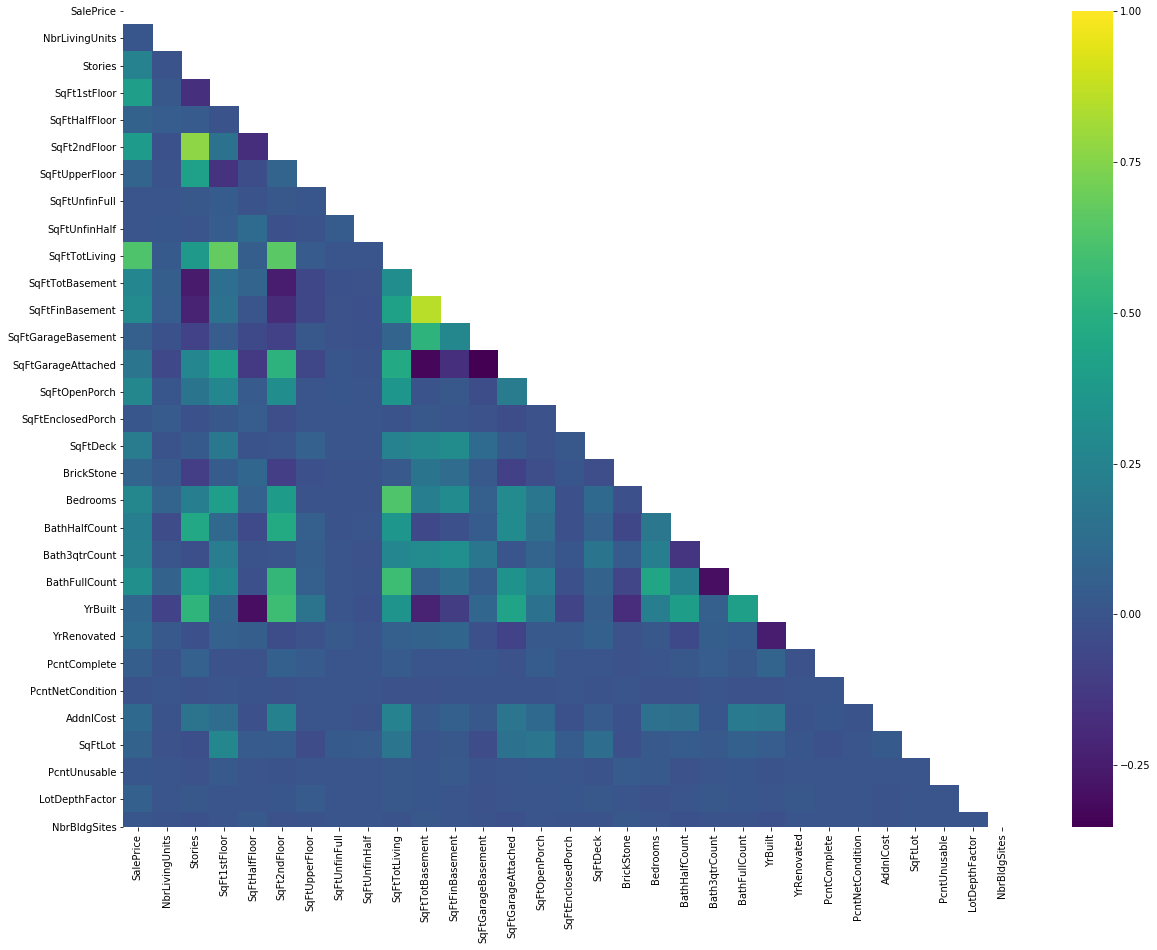

In [16]:
corr_heatmap(corr1)

A few things can be observed from the heatmap above:
- There is multicollinearity between between some features, which means that I would later need to eliminate some features and/or engineer new features that somehow combine information conveyed in various columns.

- As of now, `SqFtTotLiving` seems to have the strongest correlation with `SalePrice` (0.621684). This correlation is positive, which means that these 2 variables tend to move in the same direction. 

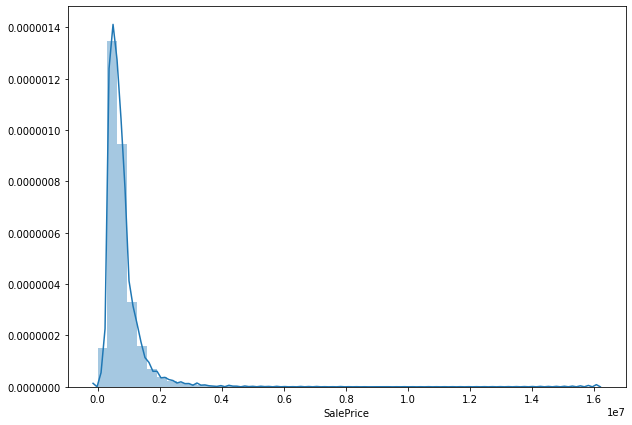

In [17]:
fig, ax = plt.subplots(figsize=(10,7))
sns.distplot(df.SalePrice);

In [18]:
df.SalePrice.mode()

0    450000
1    650000
dtype: int64

In [19]:
df.SalePrice.median()

655000.0

In [20]:
df.SalePrice.mean()

793513.6568231441

Currently, the distribution of target variable `SalePrice` is normal, but heavily right skewed (mode(s) < median < mean). This means that I have minorities of very large `SalePrice` values in my dataset. 

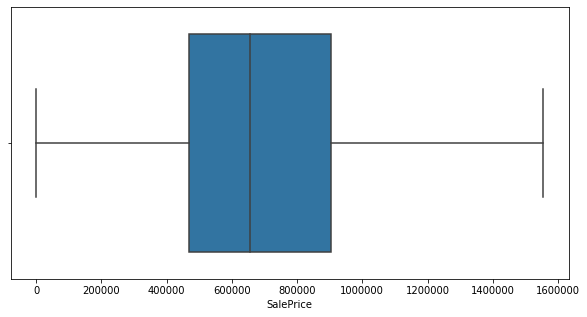

In [21]:
# boxplot with 'showfliers=False' to see how it might look like without the large valued outliers
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(df.SalePrice, showfliers=False);

## Data Modeling

### Baseline Model

The goal for this stage of the project is to have a Baseline Model up and running. For the Baseline Model, I decided with a Simple Regression Model using 01 predictor (`SqFtTotLiving`) purely because of the high correlation between it and `SalePrice`.

Also, this model would be using raw data (without any types of transformation or outliers removal, etc.) just to see what I have to start with. 

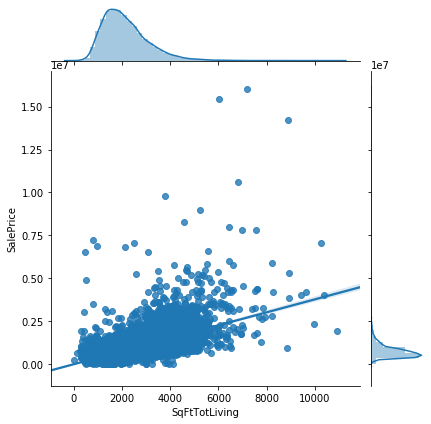

In [22]:
sns.jointplot(data=df, x='SqFtTotLiving', y='SalePrice', kind="reg");

Looking at the joint plot between `SqFtTotLiving` above, I can see that:
- They're both normally distribution, but right skewed 
- The relationship between the two are pretty linear for the most part, with some outliers seems to be pulling the line upwards a little bit.

#### First Simple Model

In [23]:
sm_1_df = df[['SalePrice', 'SqFtTotLiving']].copy()

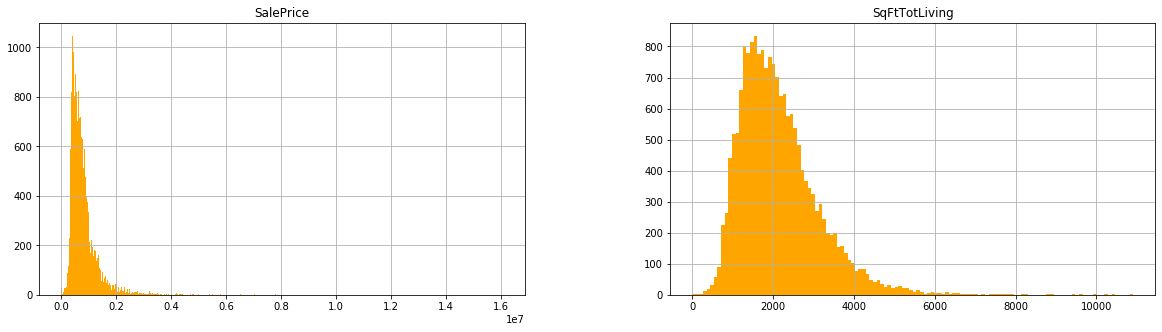

In [24]:
sm_1_df.hist(figsize=(20,5), color='orange', bins='auto');

In [25]:
outcome = 'SalePrice'
predictors = get_predictors(sm_1_df, outcome)
formula = create_formula(outcome, predictors)
sm_1 = ols(formula=formula, data=sm_1_df).fit()
sm_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                 1.154e+04
Date:                Fri, 05 Mar 2021   Prob (F-statistic):               0.00
Time:                        19:30:15   Log-Likelihood:            -2.6488e+05
No. Observations:               18320   AIC:                         5.298e+05
Df Residuals:                   18318   BIC:                         5.298e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.669e+04   8273.441     -2.017      0.044   -3.29e+04    -468.867
SqFtTotLiving   377.7096      3.516    107.423      0.000     370.818     384.601
==============================================================================
Omnibus:                    23794.512   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         13050553.171
Skew:                           6.856   Prob(JB):                         0.00
Kurtosis:                     133.034   Cond. No.                     5.72e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.72e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Model Evaluation

This first simple model is currently able to explain about **38.6%** the variance of `SalePrice`, which is not a bad start, given that this model only has 1 feature. p-value for the Intercept is 0.044, which is quite close to our significance level of 0.05, but technically still considered "statistically significant." Coefficient for `SqFtTotLiving` has a p-value of 0.000 (< 0.05) so it is also statistically significant.

- This first simple model is currently predicting a sale price of USD -16,690 when total living space is 0 sqft (which is a little strange).
- And with an increase of 1 sqft in total living space, the sale price is expected to increase by USD 377.7096, which seems to be on the higher side of average price per sqft in the US (compared to various sources on the internet).

Next, I will check how this model model is doing in terms of meeting the Linear Regression Assumptions using 3 tests:
- Rainbow Test for Linearity
- Jarque-Bera as well as QQ-plot for Normality
- Breusch-Pagan test as well as Residuals Plot for Homoskedasticity

					Statistic: 			P-value:
(Linearity) Rainbow Test: 		0.872904569730703 		0.9999999999602976
(Normality) Jarque-Bera Test: 		13050553.170671355 		0.0

					Lagrange Multiplier p-value 	F-statistic p-value:
(Homoskedasticity) Breusch-Pagan test: 	nan 				3.9310105992289626e-82


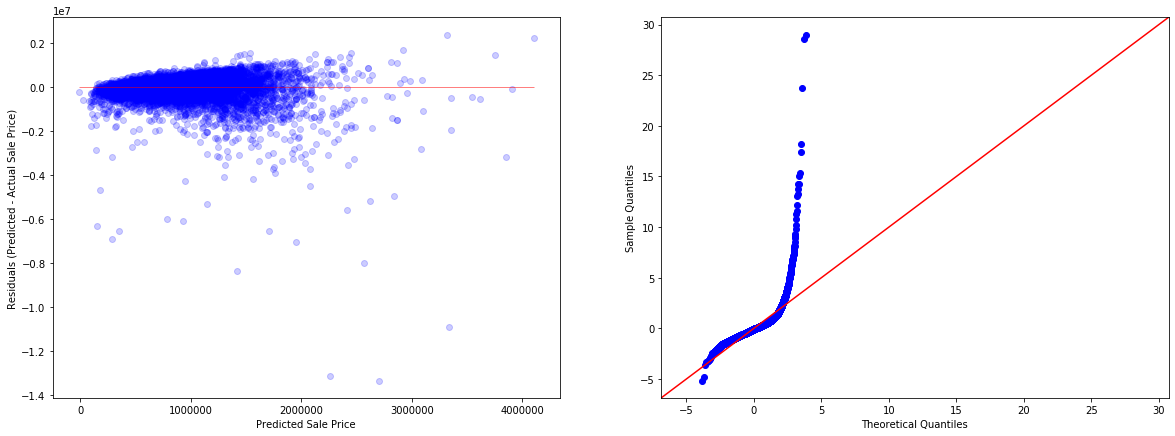

In [26]:
check_lr_assumptions(sm_1, sm_1_df, outcome, predictors)

My first simple model has only met the Linearity Assumption (since the Rainbow test p-value is 1.0, which is greater than our significance level of 0.05). Yet it's violating Normality as well as Homoskedasticity Assumptions (the p-values for both Jarque-Bera and Breusch-Pagan tests are smaller than 0.05).

This model is using only 1 feature, therefore I don't need to check for Multicollinearity yet. 

### Multiple Regression Model

As identified above, outliers in the `SalePrice` column need to be removed in order to improve the symmetry and normality of this variable. After experimenting with different types of outliers removal (using IQR vs. using z-score) and compairing models' performance, I decided to go with the z-score method because it seemed to produce higher R-squared value while keeping at least one of the Assumptions met. 

In the `model_results` dataframe (which is saved in the `data/processed/` directory under the name `model_results.pkl`, I monitor the results of all 20 models that I have trained using different transformation, as well as feature selection techniques. 

In [27]:
# import model_results dataframe 
path_to_processed = os.path.join('..', '..', 'data', 'processed')
model_results = pd.read_pickle(os.path.join(path_to_processed, 'model_results.pkl'))
model_results

,Model,Formula,R-Squared,Rainbow statistic,Rainbow p-value,Linearity Assumption,Jarque-Bera statistic,Jarque-Bera p-value,Normality Assumption,Lagrange Multiplier p-value,F-statistic p-value,Homoskedasticity Assumption,Multicollinearity,Independence Assumption,Note
0,sm_1,SalePrice ~ SqFtTotLiving,0.386491,0.872905,1.000000e+00,Satisfied,1.305055e+07,0.000000e+00,Violated,NaN,3.931011e-82,Violated,N/A,N/A,"with outliers, no transform"
1,sm_2,SalePrice ~ SqFtTotLiving,0.399934,1.027984,9.517113e-02,Satisfied,8.752700e+03,0.000000e+00,Violated,NaN,0.000000e+00,Violated,N/A,N/A,remove SalePrice outliers with z-score
2,sm_2_log,log_SalePrice ~ log_SqFtTotLiving,0.291863,1.352501,1.084791e-46,Violated,3.094762e+06,0.000000e+00,Violated,NaN,1.163439e-59,Violated,N/A,N/A,remove SalePrice outliers w/ z-scores then log...
3,sm_2_sqrt,sqrt_SalePrice ~ sqrt_SqFtTotLiving,0.379239,1.053338,6.839964e-03,Violated,1.509920e+03,0.000000e+00,Violated,NaN,0.000000e+00,Violated,N/A,N/A,remove SalePrice outliers w/ z-score & sqrt tr...
4,sm_2_sqrt_2,SalePrice ~ sqrt_SqFtTotLiving,0.375599,1.033779,5.747716e-02,Satisfied,8.842146e+03,0.000000e+00,Violated,NaN,0.000000e+00,Violated,N/A,N/A,remove SalePrice outliers w/ z-score & sqrt on...
5,sm_2_sqrt_3,sqrt_SalePrice ~ SqFtTotLiving,0.393446,1.050943,9.197660e-03,Violated,1.577432e+03,0.000000e+00,Violated,NaN,0.000000e+00,Violated,N/A,N/A,remove SalePrice outliers w/ z-score & sqrt on...
6,sm_3,SalePrice ~ SqFtTotLiving,0.308273,0.991329,6.565131e-01,Satisfied,1.038380e+03,3.300538e-226,Violated,NaN,0.000000e+00,Violated,N/A,N/A,remove SalePrice outliers w/ IQR
7,model_2_sqrt,SalePrice ~ SqFtTotLiving + sqrt_SqFtOpenPorch,0.401072,1.026429,1.079098e-01,Satisfied,8.651622e+03,0.000000e+00,Violated,0.000000e+00,0.000000e+00,Violated,,Satisfied,remove outliers w/ z-score & get sqrt of open ...
8,model_2_sqrt_all,sqrt_SalePrice ~ sqrt_SqFtTotLiving + sqrt_SqF...,0.380722,1.051251,8.860869e-03,Violated,1.487554e+03,0.000000e+00,Violated,0.000000e+00,0.000000e+00,Violated,,Satisfied,remove saleprice outliers w/ z-score & get sqr...
9,model_2_cat,SalePrice ~ SqFtTotLiving + has_OpenPorch,0.400308,1.027403,9.979305e-02,Satisfied,8.742264e+03,0.000000e+00,Violated,0.000000e+00,0.000000e+00,Violated,,Satisfied,remove saleprice outliers w/ z-score & convert...


The model that I have picked out as best-performing so far is `model_4_stepwise`. This model has an R-Squared value of 0.752139, which means it is able to explain approximately **75.2%** of the variability of target variable `SalePrice`.

I will go through the details of how I preprocessed data for this model below:

#### Data Preprocessing

In [28]:
# Remove outliers in the 'SalePrice' column 
# by default, z-score threshold is set at 3
df_4_raw = remove_outliers_z(df, 'SalePrice').copy()
df_4_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18015 entries, 0 to 821
Data columns (total 60 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   PIN                 18015 non-null  object        
 1   SalePrice           18015 non-null  int64         
 2   ExciseTaxNbr        18015 non-null  object        
 3   DocumentDate        18015 non-null  datetime64[ns]
 4   RecordingNbr        18015 non-null  object        
 5   PropertyType        18015 non-null  object        
 6   PropertyClass       18015 non-null  object        
 7   BldgNbr             18015 non-null  object        
 8   NbrLivingUnits      18015 non-null  int64         
 9   Address             18015 non-null  object        
 10  Stories             18015 non-null  float64       
 11  BldgGrade           18015 non-null  object        
 12  SqFt1stFloor        18015 non-null  int64         
 13  SqFtHalfFloor       18015 non-null  int64       

Then, to avoid issues with Multicollinearity later, I proceeded to create a few more attributes for my dataset, with the goal of eliminating duplicated info in some columns, while still retaining some important info from those intead of removing them altogether. 

In [29]:
# Add another column 'Yrs_BeforeSold' to keep track of 
# the amount of time passed instead of just the year
df_4_raw['Yrs_BeforeSold'] = 2019 - df_4_raw.YrBuilt

In [30]:
# Adding another column that only stores whether a house 
# has been renovated or not, called 'been_Renovated'
df_4_raw['been_Renovated'] = df_4_raw.YrRenovated.apply(convert_to_binary)

In this current version of the dataset, there are 14 columns that are storing information about the square footage of various parts of the properties. There would most likely some relationship among these features, not to mention relationship with some other features that keep track of the amount of Bedrooms/Bathrooms/Fireplace/etc of the properties.

Since `SqFtTotLiving` is currently my strongest predictor, I decided to base my selection/elimination of features based on how they might be correlating with `SqFtTotLiving`. I figured the information about square footage of each floor of the house can somehow be derived from `SqFtTotLiving` as well as `Stories`, and get rid of `SqFt1stFloor`, `SqFtHalfFloor`, `SqFt2ndFloor`, `SqFtUpperFloor`, `SqFtUnfinFull`, `SqFtUnfinHalf`, as well as `SqFtFinBasement`.

Some columns such as `SqFtGarageBasement`, `SqFtGarageAttached`, `SqFtOpenPorch`, `SqFtEnclosedPorch`, and `SqFtDeck` would also then be converted to binary in the same manner as I did before with `YrRenovated`.

In [31]:
to_binary = ['SqFtGarageBasement', 'SqFtGarageAttached', 'SqFtOpenPorch', 
             'SqFtEnclosedPorch', 'SqFtDeck', 'SqFtTotBasement']

for c in to_binary:
    df_4_raw[f'has_{c[4:]}'] = df_4_raw[c].apply(convert_to_binary)

In [32]:
for c in ['ViewUtilization', 'DaylightBasement']:
    print(df_4_raw[c].value_counts())
    print()

     9262
N    8379
Y     374
Name: ViewUtilization, dtype: int64

N    7380
     5983
Y    4652
Name: DaylightBasement, dtype: int64



These 2 columns `ViewUtilization`, `DaylightBasement` include empty string values, which actually takes up a good portion of the dataset. I made the assumption that empty string means 'No', and convert them to `'N'` instead.

In [33]:
for c in ['ViewUtilization', 'DaylightBasement']:
    df_4_raw[c] = df_4_raw[c].apply(lambda x: x if x in ['N', 'Y'] else 'N')

Then I identified continuous and categorical columns in the dataset that I think would be playing a role in `SalePrice`. 

(Note: Due to my lack of knowledge in Real Estate, my interpretation of some attributes might not be 100% accurate) 

In [34]:
continuous = ['SalePrice', 'SqFtTotLiving', 'Yrs_BeforeSold']
df_4_cont = df_4_raw[continuous]

# reset index for concatenating with 'df_4_cat' later
df_4_cont.index = range(len(df_4_cont))

In [35]:
df_4_cont.head()

,SalePrice,SqFtTotLiving,Yrs_BeforeSold
0,560000,1930,30
1,435000,1975,25
2,648500,3300,14
3,380000,1750,56
4,930000,2580,27


In [36]:
categoricals = ['Stories', 'BldgGrade', 'FinBasementGrade', 'DaylightBasement', 'HeatSystem', 
                'HeatSource', 'ViewUtilization', 'FpSingleStory', 'FpMultiStory', 'FpFreestanding',
                'FpAdditional', 'Condition', 'WaterSystem', 'SewerSystem', 'TrafficNoise',
                'WaterProblems', 'been_Renovated', 'Bedrooms', 
                'has_TotBasement', 'has_GarageBasement', 'has_OpenPorch',
                'has_GarageAttached', 'has_EnclosedPorch', 'has_Deck', 'DistrictName',
                'BathHalfCount', 'Bath3qtrCount', 'BathFullCount']

Then I proceeded to convert identified categorical features using `OneHotEncoder()`

In [37]:
# Apply OneHotEncoder() on categorical predictors
ohe = OneHotEncoder(drop='first')
ohe.fit(df_4_raw[categoricals])
ohe_trans = ohe.transform(df_4_raw[categoricals])

# Passing 'categoricals2' into .get_feature_names() will include original feature names 
# in our OHE columns later
column_names = ohe.get_feature_names(categoricals)

df_4_cat = pd.DataFrame(ohe_trans.todense(), columns=column_names)

In [38]:
# concatenate 'df_3_cont' and 'df_3_cat' to create df_4 preprocessed
df_4 = pd.concat([df_4_cont, df_4_cat], axis=1)

In [39]:
# Remove special characters in column names to avoid problems with
# creating R formula later on
df_4.columns = [x.replace(" ", '')
                 .replace('.', '')
                 .replace("-", "_")
                 .replace("/", "_") for x in df_4.columns]

In [40]:
df_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18015 entries, 0 to 18014
Columns: 152 entries, SalePrice to BathFullCount_7
dtypes: float64(149), int64(3)
memory usage: 20.9 MB


I then use `stepwise_selection()` to select predictors for my model based on p-value.

In [41]:
X4 = df_4.drop('SalePrice', axis=1)
y4 = df_4.SalePrice

In [42]:
predictors = stepwise_selection(X4, y4)

Add  SqFtTotLiving                  with p-value 0.0
Add  DistrictName_SEATTLE           with p-value 0.0
Add  DistrictName_BELLEVUE          with p-value 0.0
Add  DistrictName_MERCERISLAND      with p-value 2.34505e-268
Add  DistrictName_KIRKLAND          with p-value 7.6286e-254
Add  BldgGrade_10VeryGood           with p-value 9.29868e-170
Add  BldgGrade_9Better              with p-value 6.75349e-169
Add  BldgGrade_11Excellent          with p-value 4.07663e-188
Add  DistrictName_REDMOND           with p-value 4.30602e-146
Add  DistrictName_CLYDEHILL         with p-value 5.14705e-116
Add  DistrictName_MEDINA            with p-value 7.61262e-108
Add  DistrictName_FEDERALWAY        with p-value 4.66849e-80
Add  DistrictName_AUBURN            with p-value 7.9229e-79
Add  BldgGrade_8Good                with p-value 4.22254e-76
Add  Yrs_BeforeSold                 with p-value 1.50326e-91
Add  BldgGrade_12Luxury             with p-value 7.51075e-95
Add  DistrictName_KENT              with p

In [43]:
len(predictors)

79

#### Modeling

`stepwise_selection()` narrowed down the count of predictors to 81. Then I'll fit a model based on these identified predictors

In [44]:
outcome = 'SalePrice'
formula = create_formula(outcome, predictors)
model_4_stepwise = ols(formula=formula, data=df_4).fit()
model_4_stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     689.1
Date:                Fri, 05 Mar 2021   Prob (F-statistic):               0.00
Time:                        19:39:08   Log-Likelihood:            -2.4504e+05
No. Observations:               18015   AIC:                         4.902e+05
Df Residuals:                   17935   BIC:                         4.909e+05
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                     1.298e+05    1.5e+04      8.661      0.000       1e+05    1.59e+05
SqFtTotLiving                  167.6421      3.417     49.068      0.000     160.945     174.339
DistrictName_SEATTLE          2.882e+05   5456.809     52.814      0.000    2.77e+05    2.99e+05
DistrictName_BELLEVUE         3.915e+05   7917.784     49.451      0.000    3.76e+05    4.07e+05
DistrictName_MERCERISLAND      6.06e+05   1.47e+04     41.289      0.000    5.77e+05    6.35e+05
DistrictName_KIRKLAND         3.343e+05   7995.375     41.816      0.000    3.19e+05     3.5e+05
BldgGrade_10VeryGood          4.486e+05   1.14e+04     39.427      0.000    4.26e+05    4.71e+05
BldgGrade_9Better             2.747e+05   8870.935     30.971      0.000    2.57e+05    2.92e+05
BldgGrade_11Excellent         5.869e+05   1.68e+04     34.954      0.000    5.54e+05     6.2e+05
DistrictName_REDMOND           3.12e+05   1.07e+04     29.279      0.000    2.91e+05    3.33e+05
DistrictName_CLYDEHILL        1.136e+06   4.22e+04     26.917      0.000    1.05e+06    1.22e+06
DistrictName_MEDINA           1.229e+06   4.92e+04     24.960      0.000    1.13e+06    1.33e+06
DistrictName_FEDERALWAY      -1.535e+05   7903.853    -19.425      0.000   -1.69e+05   -1.38e+05
DistrictName_AUBURN           -1.49e+05   8588.154    -17.350      0.000   -1.66e+05   -1.32e+05
BldgGrade_8Good               1.268e+05   7096.584     17.869      0.000    1.13e+05    1.41e+05
Yrs_BeforeSold                1019.9650     85.965     11.865      0.000     851.464    1188.466
BldgGrade_12Luxury            6.644e+05   3.21e+04     20.690      0.000    6.01e+05    7.27e+05
DistrictName_KENT            -1.022e+05   7712.683    -13.251      0.000   -1.17e+05   -8.71e+04
DistrictName_YARROWPOINT      1.312e+06   6.55e+04     20.016      0.000    1.18e+06    1.44e+06
DistrictName_SAMMAMISH        1.558e+05   8603.058     18.115      0.000    1.39e+05    1.73e+05
DistrictName_ISSAQUAH         1.796e+05   1.22e+04     14.744      0.000    1.56e+05    2.03e+05
DistrictName_SHORELINE        1.513e+05   9739.617     15.538      0.000    1.32e+05     1.7e+05
ViewUtilization_Y             1.045e+05   1.07e+04      9.751      0.000    8.35e+04    1.26e+05
has_OpenPorch_1               3.222e+04   3278.598      9.828      0.000    2.58e+04    3.86e+04
been_Renovated_1              6.493e+04   7629.036      8.511      0.000       5e+04    7.99e+04
DistrictName_ENUMCLAW        -1.244e+05   1.41e+04     -8.809      0.000   -1.52e+05   -9.67e+04
Condition_VeryGood            5.324e+04   5403.241      9.852      0.000    4.26e+04    6.38e+04
FinBasementGrade_6LowAverage -5.648e+04   6537.971     -8.638      0.000   -6.93e+04   -4.37e+04
Condition_Good                2.945e+04   3829.554      7.691      0.000    

#### Model Evaluation

					Statistic: 			P-value:
(Linearity) Rainbow Test: 		1.111963125093244 		2.541574893365466e-07
(Normality) Jarque-Bera Test: 		39142.93730853224 		0.0

					Lagrange Multiplier p-value 	F-statistic p-value:
(Homoskedasticity) Breusch-Pagan test: 	0.0 				0.0

Independence:
                      feature        VIF
0               SqFtTotLiving  23.857425
1        DistrictName_SEATTLE   4.128962
2       DistrictName_BELLEVUE   1.436854
3   DistrictName_MERCERISLAND   1.143861
4       DistrictName_KIRKLAND   1.308765
..                        ...        ...
74            FpSingleStory_4   1.024859
75                 Bedrooms_9   1.011270
76             HeatSource_Gas   9.046393
77            FpSingleStory_2   1.207750
78             FpAdditional_3   1.008284

[79 rows x 2 columns]


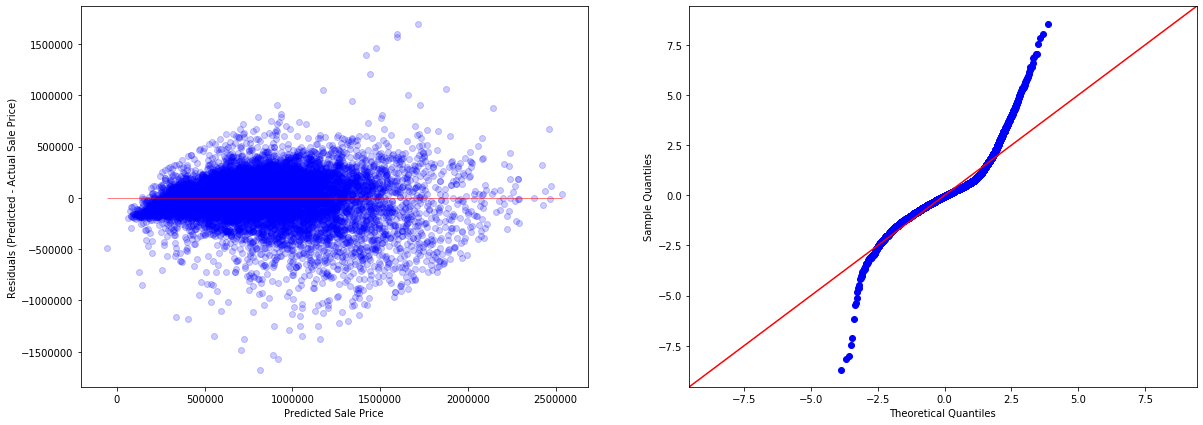

In [45]:
check_lr_assumptions(model_4_stepwise, df_4, outcome, predictors)

`model_4_stepwise` has a much higher Adjusted R-Squared than my baseline model `sm_1`. However, at a significance level of 0.05, it is violating all 4 assumptions (Linearity, Normality, Homoskedasticity) as their respective test p-values are all smaller than 0.05.

- Although compared to Baseline model, Residuals Plot seems to be improving slightly, with 0 being in the center and the absolute values of residuals seem to be smaller than that of `sm_1`. 

- QQ-Plot of `model_4_stepwise` also looks a little better and is tracing the Normal Distribution Line a little bit closer.

- In terms of Multicollinearity, there're currently 9 features in this model that have VIF values greater than 5, which indicates that these features are still highly correlated with other features used in the model.

In [46]:
vif_4 = get_vif(df_4, predictors)
vif_4[vif_4.VIF >= 5]

,feature,VIF
0,SqFtTotLiving,23.857425
13,BldgGrade_8Good,6.570320
14,Yrs_BeforeSold,9.165807
45,has_TotBasement_1,5.859879
46,SewerSystem_PUBLIC,11.056750
51,HeatSystem_ForcedAir,7.277481
66,BldgGrade_7Average,5.799276
71,WaterSystem_WATERDISTRICT,31.274725
76,HeatSource_Gas,9.046393


Then I'm going to look at the parameters for attributes belonging to certain categories using the predefined `.find_feature()`:

In [47]:
find_features("Bed", model_4_stepwise.params).sort_values(ascending=False)

Bedrooms_1    143115.425173
Bedrooms_3     27458.108473
Bedrooms_2     27408.286476
Bedrooms_6    -68800.299060
Bedrooms_9   -275755.107659
dtype: float64

--> It seems like the number of bedrooms are not positively correlated with sale price.

In [48]:
find_features("Heat", model_4_stepwise.params).sort_values(ascending=False)

HeatSource_Gas           -14468.662229
HeatSystem_ForcedAir     -21097.546651
HeatSystem_Floor_Wall    -31344.488773
HeatSource_Electricity   -42721.908880
dtype: float64

In [49]:
df_4_raw.HeatSystem.value_counts()

Forced Air    14054
Heat Pump      1517
Elec BB        1136
Floor-Wall      565
Hot Water       425
Radiant         251
Gravity          38
0                18
Other            11
Name: HeatSystem, dtype: int64

In [50]:
find_features("Garage", model_4_stepwise.params).sort_values(ascending=False)

Series([], dtype: float64)

--> No information about Garage identified in this model.

In [51]:
find_features("Porch", model_4_stepwise.params).sort_values(ascending=False)

has_OpenPorch_1    32220.960334
dtype: float64

--> Compared to having No Open Porch, having an Open Porch is going to increase the SalePrice by USD 32220.960334.

--> And no information about Enclosed Porched identified in this model

In [52]:
find_features("District", model_4_stepwise.params).sort_values(ascending=False)

DistrictName_YARROWPOINT       1.311856e+06
DistrictName_MEDINA            1.228973e+06
DistrictName_CLYDEHILL         1.135679e+06
DistrictName_BEAUXARTS         9.065209e+05
DistrictName_HUNTSPOINT        8.684673e+05
DistrictName_MERCERISLAND      6.060387e+05
DistrictName_BELLEVUE          3.915406e+05
DistrictName_KIRKLAND          3.343374e+05
DistrictName_REDMOND           3.119854e+05
DistrictName_SEATTLE           2.881954e+05
DistrictName_ISSAQUAH          1.796098e+05
DistrictName_SAMMAMISH         1.558478e+05
DistrictName_SHORELINE         1.513337e+05
DistrictName_LAKEFORESTPARK    1.379489e+05
DistrictName_NEWCASTLE         1.219269e+05
DistrictName_WOODINVILLE       9.736287e+04
DistrictName_BOTHELL           9.124265e+04
DistrictName_KENMORE           8.496760e+04
DistrictName_NORMANDYPARK      6.899758e+04
DistrictName_SNOQUALMIE        4.354923e+04
DistrictName_BURIEN            3.756981e+04
DistrictName_DESMOINES        -5.521915e+04
DistrictName_MAPLEVALLEY      -6

In [53]:
len(find_features("District", model_4_stepwise.params))

29

`model_4_stepwise` has 29 features that belong to the `DistrictName` category, which is in line with the common knowledge that location is key to valuable real estate. Looking at the coefficients of the `DistrictName` category columns, we can see the different impacts of different districts on `SalePrice`.

Since the purpose of this project is to identify the potential effects of certain home improvement projects on a property's sale price, I decided to further investigate the relationship between `SalePrice` and various features in different region of King County. 

### Regionalize by `DistrictName`

In this part of the project, I wanted to investigate how homeowners in different regions might have to invest in different home improvement projects to potentially increase the sale price of their houses.

Using `regionalize()` function, I am going to categorize these entries into different regions based on their District Name.

In [54]:
df_7_raw = df_4_raw.copy()
df_7_raw['Region'] = df_7_raw.DistrictName.apply(regionalize)

In [55]:
region = df_7_raw['Region']
region.index = range(len(region))

Then, I proceeded to select the continuous and categorical columns:

In [56]:
continuous = ['SalePrice', 'SqFtTotLiving', 'Yrs_BeforeSold']

df_7_cont = df_7_raw[continuous]

# reset index for df_3_cont for concatenating with df_3_cat later
df_7_cont.index = range(len(df_7_cont))

Instead of having 2 different features for Garage, I combined them both into 1 called `has_Garage` that only stores the information of whether or not a property has garage, not what type of garage it is.

In [57]:
df_7_raw['Garage'] = df_7_raw.SqFtGarageBasement + df_7_raw.SqFtGarageAttached
df_7_raw['has_Garage'] = df_7_raw['Garage'].apply(convert_to_binary)

In [58]:
# Update the list of categorical features
categoricals = ['Stories', 'BldgGrade', 'DaylightBasement', 'HeatSystem', 
                'HeatSource', 'ViewUtilization', 'FpSingleStory', 'FpMultiStory', 'FpFreestanding',
                'FpAdditional', 'Condition', 'WaterSystem', 'SewerSystem', 'TrafficNoise',
                'WaterProblems', 'been_Renovated', 'has_Garage', 'has_TotBasement', 
                'has_OpenPorch', 'has_EnclosedPorch', 'has_Deck',
                'Bedrooms', 'BathHalfCount', 'Bath3qtrCount', 'BathFullCount']

In [59]:
# Apply OneHotEncoder() on categorical predictors
ohe = OneHotEncoder(drop='first')
ohe.fit(df_7_raw[categoricals])
ohe_trans = ohe.transform(df_7_raw[categoricals])

# Passing 'categoricals' into .get_feature_names() will include original feature names 
# in our OHE columns later
column_names = ohe.get_feature_names(categoricals)

df_7_cat = pd.DataFrame(ohe_trans.todense(), columns=column_names)

In [60]:
# concatenate 'df_7_cont' and 'df_7_cat' to create df_7_final
df_7 = pd.concat([df_7_cont, df_7_cat, region], axis=1)

In [61]:
clean_col_names(df_7)

In [62]:
df_7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18015 entries, 0 to 18014
Columns: 102 entries, SalePrice to Region
dtypes: float64(98), int64(3), object(1)
memory usage: 14.0+ MB


Then I split `df_7` into 4 separate dataframes `north`, `south`, `east`, `seattle`.

In [63]:
df_7_north = df_7[df_7.Region == 'North'].drop('Region', axis=1)
df_7_south = df_7[df_7.Region == 'South'].drop('Region', axis=1)
df_7_east = df_7[df_7.Region == 'East'].drop('Region', axis=1)
df_7_seattle = df_7[df_7.Region == 'Seattle'].drop('Region', axis=1)

#### North

In [64]:
X7_north = df_7_north.drop('SalePrice', axis=1)
y7_north = df_7_north.SalePrice

In [65]:
predictors_north = stepwise_selection(X7_north, y7_north)

Add  SqFtTotLiving                  with p-value 2.54217e-212
Add  BldgGrade_10VeryGood           with p-value 2.14495e-09
Add  BldgGrade_9Better              with p-value 3.47399e-12
Add  BldgGrade_11Excellent          with p-value 1.14046e-10
Add  BldgGrade_8Good                with p-value 1.99986e-08
Add  been_Renovated_1               with p-value 3.10108e-07
Add  Condition_VeryGood             with p-value 1.20807e-07
Add  has_EnclosedPorch_1            with p-value 6.64169e-05
Add  TrafficNoise_MODERATE          with p-value 7.77832e-05
Add  HeatSource_Oil                 with p-value 0.000250998
Add  TrafficNoise_HIGH              with p-value 0.00288974


In [66]:
len(predictors_north)

11

In [67]:
outcome = 'SalePrice'
formula = create_formula(outcome, predictors_north)
model_7_north_stepwise = ols(formula=formula, data=df_7_north).fit()
model_7_north_stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     196.8
Date:                Fri, 05 Mar 2021   Prob (F-statistic):          1.76e-256
Time:                        19:39:48   Log-Likelihood:                -15708.
No. Observations:                1177   AIC:                         3.144e+04
Df Residuals:                    1165   BIC:                         3.150e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              3.018e+05   1.46e+04     20.733      0.000    2.73e+05     3.3e+05
SqFtTotLiving           153.4632      7.530     20.380      0.000     138.689     168.238
BldgGrade_10VeryGood   3.623e+05   3.37e+04     10.751      0.000    2.96e+05    4.28e+05
BldgGrade_9Better      2.081e+05   1.85e+04     11.248      0.000    1.72e+05    2.44e+05
BldgGrade_11Excellent  5.296e+05   6.12e+04      8.650      0.000     4.1e+05     6.5e+05
BldgGrade_8Good        8.216e+04   1.15e+04      7.158      0.000    5.96e+04    1.05e+05
been_Renovated_1       1.312e+05   2.54e+04      5.165      0.000    8.13e+04    1.81e+05
Condition_VeryGood     7.725e+04   1.35e+04      5.717      0.000    5.07e+04    1.04e+05
has_EnclosedPorch_1    1.387e+05   3.39e+04      4.089      0.000    7.21e+04    2.05e+05
TrafficNoise_MODERATE -6.028e+04   1.36e+04     -4.420      0.000    -8.7e+04   -3.35e+04
HeatSource_Oil         5.216e+04   1.39e+04      3.746      0.000    2.48e+04    7.95e+04
TrafficNoise_HIGH     -6.566e+04    2.2e+04     -2.986      0.003   -1.09e+05   -2.25e+04
==============================================================================
Omnibus:                      467.281   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7493.777
Skew:                           1.396   Prob(JB):                         0.00
Kurtosis:                      15.042   Cond. No.                     3.21e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.21e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

					Statistic: 			P-value:
(Linearity) Rainbow Test: 		1.5635886367577665 		4.060119012060247e-08
(Normality) Jarque-Bera Test: 		7493.777277936144 		0.0

					Lagrange Multiplier p-value 	F-statistic p-value:
(Homoskedasticity) Breusch-Pagan test: 	7.081573980041613e-30 				1.2696707586949083e-31

Independence:
                  feature       VIF
0           SqFtTotLiving  3.907354
1    BldgGrade_10VeryGood  1.243461
2       BldgGrade_9Better  1.667804
3   BldgGrade_11Excellent  1.074820
4         BldgGrade_8Good  2.210395
5        been_Renovated_1  1.085850
6      Condition_VeryGood  1.162624
7     has_EnclosedPorch_1  1.044445
8   TrafficNoise_MODERATE  1.122916
9          HeatSource_Oil  1.128736
10      TrafficNoise_HIGH  1.046594


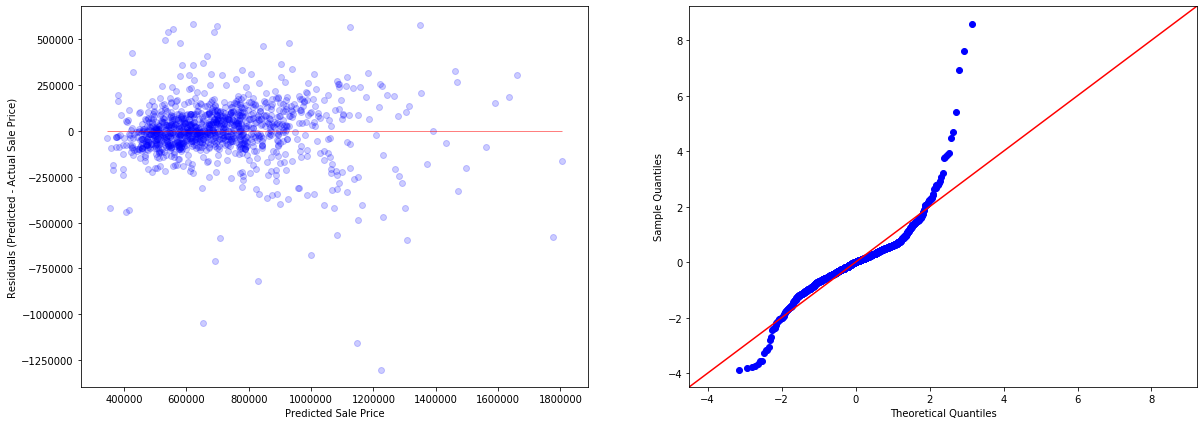

In [68]:
check_lr_assumptions(model_7_north_stepwise, df_7_north, outcome, predictors_north)

#### South

In [69]:
X7_south = df_7_south.drop('SalePrice', axis=1)
y7_south = df_7_south.SalePrice

In [70]:
predictors_south = stepwise_selection(X7_south, y7_south)

Add  SqFtTotLiving                  with p-value 0.0
Add  BldgGrade_11Excellent          with p-value 3.58286e-40
Add  BldgGrade_10VeryGood           with p-value 1.25006e-32
Add  BldgGrade_9Better              with p-value 1.80443e-38
Add  HeatSystem_HeatPump            with p-value 5.27911e-27
Add  been_Renovated_1               with p-value 1.30855e-18
Add  BldgGrade_8Good                with p-value 5.79254e-20
Add  BldgGrade_12Luxury             with p-value 6.63361e-16
Add  HeatSource_Oil                 with p-value 1.18907e-11
Add  Bath3qtrCount_4                with p-value 4.43615e-08
Add  FpSingleStory_5                with p-value 4.43615e-08
Add  Bath3qtrCount_2                with p-value 6.60728e-08
Add  Bedrooms_1                     with p-value 2.80203e-07
Add  Stories_30                     with p-value 5.25879e-07
Add  BldgGrade_7Average             with p-value 2.84236e-06
Add  FpMultiStory_1                 with p-value 4.9098e-05
Add  HeatSystem_HotWater         

In [71]:
len(predictors_south)

23

In [72]:
outcome = 'SalePrice'
formula = create_formula(outcome, predictors_south)
model_7_south_stepwise = ols(formula=formula, data=df_7_south).fit()
model_7_south_stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     291.2
Date:                Fri, 05 Mar 2021   Prob (F-statistic):               0.00
Time:                        19:40:11   Log-Likelihood:                -66143.
No. Observations:                5054   AIC:                         1.323e+05
Df Residuals:                    5031   BIC:                         1.325e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              1.976e+05   6746.183     29.293      0.000    1.84e+05    2.11e+05
SqFtTotLiving            93.8772      3.416     27.486      0.000      87.181     100.573
BldgGrade_11Excellent   5.79e+05   3.13e+04     18.526      0.000    5.18e+05     6.4e+05
BldgGrade_10VeryGood   2.899e+05   1.57e+04     18.510      0.000    2.59e+05    3.21e+05
BldgGrade_9Better       1.62e+05   9506.248     17.045      0.000    1.43e+05    1.81e+05
HeatSystem_HeatPump    7.218e+04   6675.862     10.813      0.000    5.91e+04    8.53e+04
been_Renovated_1       8.852e+04   9435.528      9.382      0.000       7e+04    1.07e+05
BldgGrade_8Good        7.899e+04   6839.204     11.549      0.000    6.56e+04    9.24e+04
BldgGrade_12Luxury     7.217e+05   8.64e+04      8.350      0.000    5.52e+05    8.91e+05
HeatSource_Oil         4.786e+04   6664.327      7.181      0.000    3.48e+04    6.09e+04
Bath3qtrCount_4        3.759e+05   6.03e+04      6.231      0.000    2.58e+05    4.94e+05
FpSingleStory_5        3.759e+05   6.03e+04      6.231      0.000    2.58e+05    4.94e+05
Bath3qtrCount_2        4.363e+04   8184.708      5.330      0.000    2.76e+04    5.97e+04
Bedrooms_1             1.384e+05   2.06e+04      6.728      0.000     9.8e+04    1.79e+05
Stories_30               2.4e+05   4.81e+04      4.994      0.000    1.46e+05    3.34e+05
BldgGrade_7Average     2.913e+04   5469.590      5.326      0.000    1.84e+04    3.99e+04
FpMultiStory_1        -2.005e+04   4320.959     -4.641      0.000   -2.85e+04   -1.16e+04
HeatSystem_HotWater    5.296e+04   1.85e+04      2.856      0.004    1.66e+04    8.93e+04
has_Deck_1             1.194e+04   3670.076      3.253      0.001    4743.668    1.91e+04
has_OpenPorch_1        1.308e+04   3644.544      3.590      0.000    5938.664    2.02e+04
Condition_VeryGood     2.231e+04   5668.691      3.936      0.000    1.12e+04    3.34e+04
Condition_Good          1.25e+04   3916.330      3.192      0.001    4824.297    2.02e+04
BldgGrade_4Low        -1.687e+05   5.61e+04     -3.005      0.003   -2.79e+05   -5.86e+04
Bedrooms_6            -4.897e+04   1.73e+04     -2.825      0.005    -8.3e+04    -1.5e+04
==============================================================================
Omnibus:                     4084.443   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           260968.080
Skew:                           3.394   Prob(JB):                         0.00
Kurtosis:                      37.543   Cond. No.                     2.09e+21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.27e-33. This might indicate that there are


					Statistic: 			P-value:
(Linearity) Rainbow Test: 		1.302836768432861 		1.7507667446481034e-11
(Normality) Jarque-Bera Test: 		260968.08040101378 		0.0

					Lagrange Multiplier p-value 	F-statistic p-value:
(Homoskedasticity) Breusch-Pagan test: 	2.312547233011107e-85 				6.069336151125491e-90

Independence:
                  feature        VIF
0           SqFtTotLiving  12.791508
1   BldgGrade_11Excellent   1.134704
2    BldgGrade_10VeryGood   1.601662
3       BldgGrade_9Better   2.669095
4     HeatSystem_HeatPump   1.125492
5        been_Renovated_1   1.059045
6         BldgGrade_8Good   4.583252
7      BldgGrade_12Luxury   1.076520
8          HeatSource_Oil   1.107174
9         Bath3qtrCount_4        inf
10        FpSingleStory_5        inf
11        Bath3qtrCount_2   1.128406
12             Bedrooms_1   1.160066
13             Stories_30   1.011072
14     BldgGrade_7Average   4.373823
15         FpMultiStory_1   1.580512
16    HeatSystem_HotWater   1.047677
17             has_

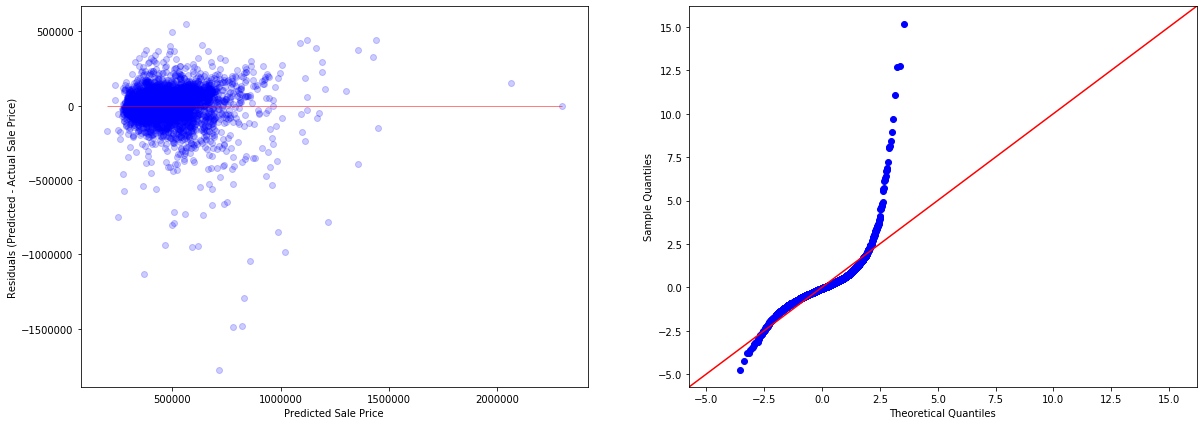

In [73]:
check_lr_assumptions(model_7_south_stepwise, df_7_south, outcome, predictors_south)

#### East

In [74]:
X7_east = df_7_east.drop('SalePrice', axis=1)
y7_east = df_7_east.SalePrice

In [75]:
predictors_east = stepwise_selection(X7_east, y7_east)

Add  SqFtTotLiving                  with p-value 0.0
Add  SewerSystem_PRIVATE            with p-value 2.26998e-99
Add  BldgGrade_10VeryGood           with p-value 1.07128e-55
Add  BldgGrade_11Excellent          with p-value 2.04895e-43
Add  BldgGrade_9Better              with p-value 3.69361e-50
Add  BldgGrade_12Luxury             with p-value 2.33005e-33
Add  been_Renovated_1               with p-value 7.91781e-32
Add  BldgGrade_8Good                with p-value 7.40237e-22
Add  Stories_20                     with p-value 1.3393e-27
Add  Bath3qtrCount_2                with p-value 4.64228e-11
Add  Yrs_BeforeSold                 with p-value 4.9764e-11
Add  Bath3qtrCount_1                with p-value 3.04515e-08
Add  BldgGrade_6LowAverage          with p-value 1.24032e-06
Add  has_Garage_1                   with p-value 3.0073e-09
Add  FpMultiStory_4                 with p-value 2.42529e-06
Add  Bedrooms_4                     with p-value 1.46862e-06
Add  BathFullCount_3               

In [76]:
len(predictors_east)

31

In [77]:
outcome = 'SalePrice'
formula = create_formula(outcome, predictors_east)
model_7_east_stepwise = ols(formula=formula, data=df_7_east).fit()
model_7_east_stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     354.5
Date:                Fri, 05 Mar 2021   Prob (F-statistic):               0.00
Time:                        19:40:52   Log-Likelihood:                -89864.
No. Observations:                6459   AIC:                         1.798e+05
Df Residuals:                    6427   BIC:                         1.800e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 3.5e+05    2.3e+04     15.235      0.000    3.05e+05    3.95e+05
SqFtTotLiving            172.8627      6.780     25.495      0.000     159.571     186.154
SewerSystem_PRIVATE    -1.798e+05   7980.048    -22.537      0.000   -1.95e+05   -1.64e+05
BldgGrade_10VeryGood     5.14e+05   1.67e+04     30.825      0.000    4.81e+05    5.47e+05
BldgGrade_11Excellent   6.276e+05   2.55e+04     24.643      0.000    5.78e+05    6.78e+05
BldgGrade_9Better       3.113e+05   1.31e+04     23.796      0.000    2.86e+05    3.37e+05
BldgGrade_12Luxury      7.335e+05   4.58e+04     15.997      0.000    6.44e+05    8.23e+05
been_Renovated_1        1.865e+05    1.9e+04      9.807      0.000    1.49e+05    2.24e+05
BldgGrade_8Good         1.119e+05   9622.257     11.629      0.000     9.3e+04    1.31e+05
Stories_20             -6.807e+04   1.02e+04     -6.649      0.000   -8.81e+04    -4.8e+04
Bath3qtrCount_2         1.596e+05   1.61e+04      9.940      0.000    1.28e+05    1.91e+05
Yrs_BeforeSold          1312.2856    258.171      5.083      0.000     806.184    1818.388
Bath3qtrCount_1         7.032e+04   8985.538      7.826      0.000    5.27e+04    8.79e+04
BldgGrade_6LowAverage  -9.348e+04   1.74e+04     -5.374      0.000   -1.28e+05   -5.94e+04
has_Garage_1           -5.708e+04   1.04e+04     -5.504      0.000   -7.74e+04   -3.67e+04
FpMultiStory_4         -1.302e+06   2.73e+05     -4.771      0.000   -1.84e+06   -7.67e+05
Bedrooms_4             -2.993e+04   7299.899     -4.100      0.000   -4.42e+04   -1.56e+04
BathFullCount_3         7.285e+04   1.33e+04      5.460      0.000    4.67e+04     9.9e+04
BathFullCount_4         1.464e+05   3.21e+04      4.563      0.000    8.35e+04    2.09e+05
Condition_VeryGood      7.129e+04   1.26e+04      5.639      0.000    4.65e+04    9.61e+04
Condition_Good          5.002e+04   8662.535      5.774      0.000     3.3e+04     6.7e+04
HeatSystem_HotWater     1.421e+05   4.55e+04      3.126      0.002     5.3e+04    2.31e+05
Bedrooms_2              5.722e+04   1.54e+04      3.721      0.000    2.71e+04    8.74e+04
HeatSource_Electricity -5.229e+04   1.19e+04     -4.376      0.000   -7.57e+04   -2.89e+04
has_OpenPorch_1         2.196e+04   7725.650      2.843      0.004    6815.485    3.71e+04
BathHalfCount_1         3.568e+04   8529.212      4.184      0.000     1.9e+04    5.24e+04
BathFullCount_1        -3.752e+04   1.03e+04     -3.633      0.000   -5.78e+04   -1.73e+04
has_TotBasement_1      -3.058e+04   8243.276     -3.710      0.000   -4.67e+04   -1.44e+04
Stories_15             -5.701e+04    1.7e+04     -3.360      0.001   -9.03e+04   -2.37e+04
HeatSystem_ForcedAir   -3.325e+04   1.11e+04     -2.984      0.003   -5.51e+04   -1.14e+04
FpAdditional_2          1.114e+05   3.77e+04      2.952      0.003    3.74e+04  

					Statistic: 			P-value:
(Linearity) Rainbow Test: 		1.0527421735131426 		0.07262844647390472
(Normality) Jarque-Bera Test: 		5712.19047850959 		0.0

					Lagrange Multiplier p-value 	F-statistic p-value:
(Homoskedasticity) Breusch-Pagan test: 	4.6754850050723974e-256 				5.08864982471585e-287

Independence:
                   feature        VIF
0            SqFtTotLiving  22.823585
1      SewerSystem_PRIVATE   1.681548
2     BldgGrade_10VeryGood   2.449581
3    BldgGrade_11Excellent   1.685329
4        BldgGrade_9Better   2.932018
5       BldgGrade_12Luxury   1.209526
6         been_Renovated_1   1.248628
7          BldgGrade_8Good   2.625351
8               Stories_20   4.462705
9          Bath3qtrCount_2   1.830412
10          Yrs_BeforeSold   7.839441
11         Bath3qtrCount_1   2.890823
12   BldgGrade_6LowAverage   1.394223
13            has_Garage_1   6.530014
14          FpMultiStory_4   1.037376
15              Bedrooms_4   2.006901
16         BathFullCount_3   1.508959
17 

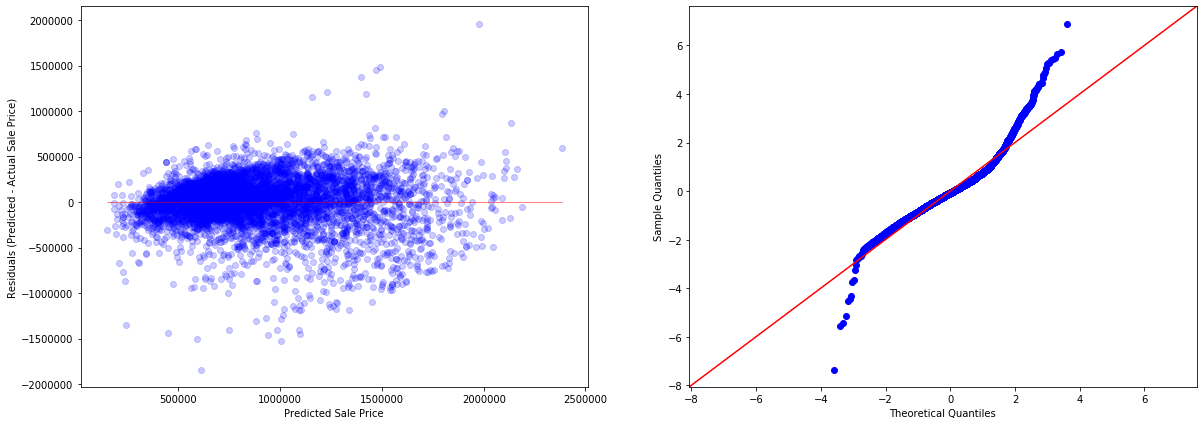

In [78]:
check_lr_assumptions(model_7_east_stepwise, df_7_east, outcome, predictors_east)

#### Seattle

In [79]:
X7_seattle = df_7_seattle.drop('SalePrice', axis=1)
y7_seattle = df_7_seattle.SalePrice

In [80]:
predictors_seattle = stepwise_selection(X7_seattle, y7_seattle)

Add  SqFtTotLiving                  with p-value 0.0
Add  BldgGrade_9Better              with p-value 1.76454e-74
Add  BldgGrade_10VeryGood           with p-value 2.07029e-102
Add  Yrs_BeforeSold                 with p-value 1.21748e-44
Add  BldgGrade_8Good                with p-value 1.01021e-94
Add  BldgGrade_11Excellent          with p-value 3.34613e-58
Add  BldgGrade_6LowAverage          with p-value 3.51262e-20
Add  FpAdditional_1                 with p-value 6.82491e-10
Add  Bedrooms_1                     with p-value 4.56867e-10
Add  BldgGrade_12Luxury             with p-value 2.47206e-09
Add  Condition_VeryGood             with p-value 1.44607e-06
Add  Condition_Good                 with p-value 3.58274e-07
Add  DaylightBasement_Y             with p-value 1.69226e-06
Add  FpMultiStory_1                 with p-value 1.72795e-06
Add  has_OpenPorch_1                with p-value 3.11515e-05
Add  TrafficNoise_HIGH              with p-value 4.80935e-05
Add  BldgGrade_7Average        

In [81]:
len(predictors_seattle)

28

In [82]:
outcome = 'SalePrice'
formula = create_formula(outcome, predictors_seattle)
model_7_seattle_stepwise = ols(formula=formula, data=df_7_seattle).fit()
model_7_seattle_stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     409.2
Date:                Fri, 05 Mar 2021   Prob (F-statistic):               0.00
Time:                        19:41:27   Log-Likelihood:                -72753.
No. Observations:                5325   AIC:                         1.456e+05
Df Residuals:                    5296   BIC:                         1.458e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               9.999e+04   1.36e+04      7.349      0.000    7.33e+04    1.27e+05
SqFtTotLiving            214.8742      5.736     37.458      0.000     203.629     226.120
BldgGrade_9Better       4.964e+05   1.57e+04     31.602      0.000    4.66e+05    5.27e+05
BldgGrade_10VeryGood    7.799e+05   2.39e+04     32.574      0.000    7.33e+05    8.27e+05
Yrs_BeforeSold          2139.4690    113.710     18.815      0.000    1916.551    2362.387
BldgGrade_8Good         2.509e+05   1.21e+04     20.767      0.000    2.27e+05    2.75e+05
BldgGrade_11Excellent    1.01e+06   5.63e+04     17.944      0.000       9e+05    1.12e+06
FpAdditional_1         -6.583e+04   1.12e+04     -5.904      0.000   -8.77e+04    -4.4e+04
Bedrooms_1              1.563e+05   2.15e+04      7.263      0.000    1.14e+05    1.99e+05
BldgGrade_12Luxury      1.324e+06   2.09e+05      6.319      0.000    9.13e+05    1.73e+06
Condition_VeryGood      6.392e+04   1.01e+04      6.301      0.000     4.4e+04    8.38e+04
Condition_Good          3.832e+04   7754.356      4.942      0.000    2.31e+04    5.35e+04
DaylightBasement_Y      -3.79e+04   7052.698     -5.373      0.000   -5.17e+04   -2.41e+04
FpMultiStory_1          4.391e+04   9194.935      4.775      0.000    2.59e+04    6.19e+04
has_OpenPorch_1         2.451e+04   6243.136      3.926      0.000    1.23e+04    3.67e+04
TrafficNoise_HIGH      -4.453e+04   1.05e+04     -4.242      0.000   -6.51e+04   -2.39e+04
BldgGrade_7Average      9.153e+04   9880.732      9.264      0.000    7.22e+04    1.11e+05
BathFullCount_5         9.648e+05    2.1e+05      4.586      0.000    5.52e+05    1.38e+06
Bedrooms_6             -1.153e+05   2.74e+04     -4.202      0.000   -1.69e+05   -6.15e+04
Bedrooms_9             -6.831e+05    2.1e+05     -3.259      0.001   -1.09e+06   -2.72e+05
has_Deck_1              2.177e+04   6187.470      3.519      0.000    9642.945    3.39e+04
BathFullCount_3         4.424e+04   1.24e+04      3.554      0.000    1.98e+04    6.86e+04
Stories_25              9.501e+04   2.45e+04      3.876      0.000     4.7e+04    1.43e+05
has_EnclosedPorch_1    -3.856e+04   1.07e+04     -3.596      0.000   -5.96e+04   -1.75e+04
HeatSystem_HeatPump     5.451e+04    1.1e+04      4.938      0.000    3.29e+04    7.62e+04
HeatSource_Electricity -3.607e+04   8061.058     -4.474      0.000   -5.19e+04   -2.03e+04
BathHalfCount_2          8.54e+04   2.84e+04      3.005      0.003    2.97e+04    1.41e+05
Stories_20              2.258e+04   7711.625      2.928      0.003    7460.346    3.77e+04
TrafficNoise_EXTREME   -8.227e+04    3.1e+04     -2.655      0.008   -1.43e+05   -2.15e+04
==============================================================================
Omnibus:                      981.514   Durbin-Watson:                   1.964
Prob(Omnibus)

					Statistic: 			P-value:
(Linearity) Rainbow Test: 		1.0127383154304785 		0.37236421156525223
(Normality) Jarque-Bera Test: 		5489.383545884681 		0.0

					Lagrange Multiplier p-value 	F-statistic p-value:
(Homoskedasticity) Breusch-Pagan test: 	3.7594122866675685e-210 				1.5855188132858856e-235

Independence:
                   feature        VIF
0            SqFtTotLiving  13.843393
1        BldgGrade_9Better   3.060355
2     BldgGrade_10VeryGood   1.678288
3           Yrs_BeforeSold   5.083568
4          BldgGrade_8Good   4.055821
5    BldgGrade_11Excellent   1.091365
6           FpAdditional_1   2.178722
7               Bedrooms_1   1.051132
8       BldgGrade_12Luxury   1.011238
9       Condition_VeryGood   1.283408
10          Condition_Good   1.516191
11      DaylightBasement_Y   1.616338
12          FpMultiStory_1   2.466224
13         has_OpenPorch_1   1.960357
14       TrafficNoise_HIGH   1.091588
15      BldgGrade_7Average   3.684320
16         BathFullCount_5   1.020981


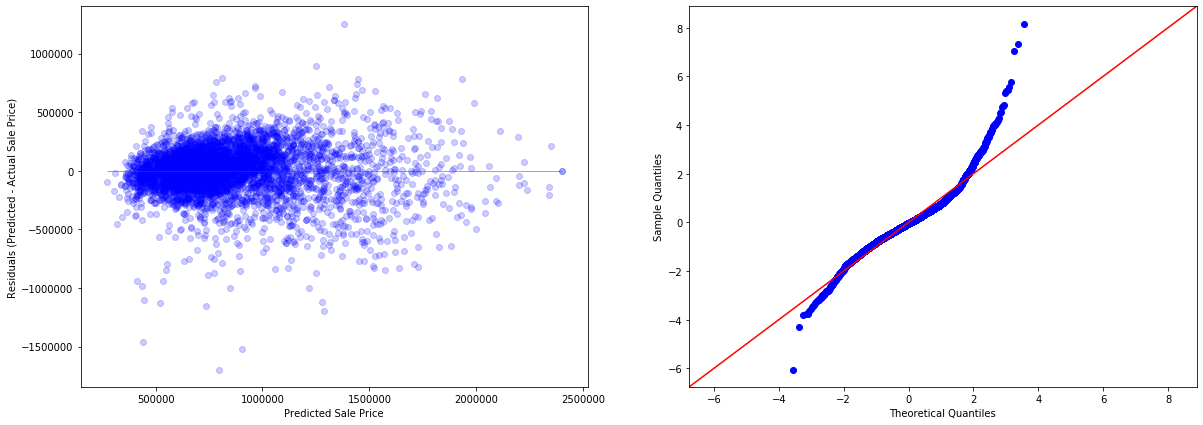

In [83]:
check_lr_assumptions(model_7_seattle_stepwise, df_7_seattle, outcome, predictors_seattle)

#### Model Evaluation

In [84]:
model_results

,Model,Formula,R-Squared,Rainbow statistic,Rainbow p-value,Linearity Assumption,Jarque-Bera statistic,Jarque-Bera p-value,Normality Assumption,Lagrange Multiplier p-value,F-statistic p-value,Homoskedasticity Assumption,Multicollinearity,Independence Assumption,Note
0,sm_1,SalePrice ~ SqFtTotLiving,0.386491,0.872905,1.000000e+00,Satisfied,1.305055e+07,0.000000e+00,Violated,NaN,3.931011e-82,Violated,N/A,N/A,"with outliers, no transform"
1,sm_2,SalePrice ~ SqFtTotLiving,0.399934,1.027984,9.517113e-02,Satisfied,8.752700e+03,0.000000e+00,Violated,NaN,0.000000e+00,Violated,N/A,N/A,remove SalePrice outliers with z-score
2,sm_2_log,log_SalePrice ~ log_SqFtTotLiving,0.291863,1.352501,1.084791e-46,Violated,3.094762e+06,0.000000e+00,Violated,NaN,1.163439e-59,Violated,N/A,N/A,remove SalePrice outliers w/ z-scores then log...
3,sm_2_sqrt,sqrt_SalePrice ~ sqrt_SqFtTotLiving,0.379239,1.053338,6.839964e-03,Violated,1.509920e+03,0.000000e+00,Violated,NaN,0.000000e+00,Violated,N/A,N/A,remove SalePrice outliers w/ z-score & sqrt tr...
4,sm_2_sqrt_2,SalePrice ~ sqrt_SqFtTotLiving,0.375599,1.033779,5.747716e-02,Satisfied,8.842146e+03,0.000000e+00,Violated,NaN,0.000000e+00,Violated,N/A,N/A,remove SalePrice outliers w/ z-score & sqrt on...
5,sm_2_sqrt_3,sqrt_SalePrice ~ SqFtTotLiving,0.393446,1.050943,9.197660e-03,Violated,1.577432e+03,0.000000e+00,Violated,NaN,0.000000e+00,Violated,N/A,N/A,remove SalePrice outliers w/ z-score & sqrt on...
6,sm_3,SalePrice ~ SqFtTotLiving,0.308273,0.991329,6.565131e-01,Satisfied,1.038380e+03,3.300538e-226,Violated,NaN,0.000000e+00,Violated,N/A,N/A,remove SalePrice outliers w/ IQR
7,model_2_sqrt,SalePrice ~ SqFtTotLiving + sqrt_SqFtOpenPorch,0.401072,1.026429,1.079098e-01,Satisfied,8.651622e+03,0.000000e+00,Violated,0.000000e+00,0.000000e+00,Violated,,Satisfied,remove outliers w/ z-score & get sqrt of open ...
8,model_2_sqrt_all,sqrt_SalePrice ~ sqrt_SqFtTotLiving + sqrt_SqF...,0.380722,1.051251,8.860869e-03,Violated,1.487554e+03,0.000000e+00,Violated,0.000000e+00,0.000000e+00,Violated,,Satisfied,remove saleprice outliers w/ z-score & get sqr...
9,model_2_cat,SalePrice ~ SqFtTotLiving + has_OpenPorch,0.400308,1.027403,9.979305e-02,Satisfied,8.742264e+03,0.000000e+00,Violated,0.000000e+00,0.000000e+00,Violated,,Satisfied,remove saleprice outliers w/ z-score & convert...


Compared to the 17 above models:
- **East** and **Seattle** models are meeting the Linearity Assumption


- **North** is also meeting the Multicollinearity assumption

(These are all considered progress compared to previous models ran on the whole dataset. Although overall the Adjusted R-squared values of these models are smaller than `model_4_stepwise`'s they have a lot less predictors).

- In addition, QQ-plots for all 4 models also look like they're tracing the normal line more closely than the previously best performing model `model_4_stepwise`. 

Tailoring models based on geographic regions seems to have helped narrow down the list of most prominent features for each regions. We can see that they differ going from one region to another:

In [85]:
model_7_north_stepwise.params.sort_values(ascending=False)

BldgGrade_11Excellent    529635.931261
BldgGrade_10VeryGood     362328.130749
Intercept                301768.878172
BldgGrade_9Better        208055.561190
has_EnclosedPorch_1      138693.658964
been_Renovated_1         131178.994186
BldgGrade_8Good           82155.893172
Condition_VeryGood        77249.593463
HeatSource_Oil            52164.369115
SqFtTotLiving               153.463189
TrafficNoise_MODERATE    -60275.450322
TrafficNoise_HIGH        -65655.183354
dtype: float64

In [86]:
model_7_south_stepwise.params.sort_values(ascending=False)

BldgGrade_12Luxury       721702.828696
BldgGrade_11Excellent    578963.617759
FpSingleStory_5          375935.302588
Bath3qtrCount_4          375935.302588
BldgGrade_10VeryGood     289932.348898
Stories_30               240020.793238
Intercept                197613.449608
BldgGrade_9Better        162038.281368
Bedrooms_1               138353.756983
been_Renovated_1          88519.986429
BldgGrade_8Good           78985.823195
HeatSystem_HeatPump       72183.967173
HeatSystem_HotWater       52957.971219
HeatSource_Oil            47855.282018
Bath3qtrCount_2           43626.564850
BldgGrade_7Average        29128.533501
Condition_VeryGood        22309.739249
has_OpenPorch_1           13083.558687
Condition_Good            12502.010377
has_Deck_1                11938.616296
SqFtTotLiving                93.877156
FpMultiStory_1           -20053.434843
Bedrooms_6               -48971.410646
BldgGrade_4Low          -168706.096122
dtype: float64

In [87]:
model_7_east_stepwise.params.sort_values(ascending=False)

BldgGrade_12Luxury        7.334610e+05
BldgGrade_11Excellent     6.276256e+05
BldgGrade_10VeryGood      5.139995e+05
Intercept                 3.499718e+05
BldgGrade_9Better         3.113092e+05
been_Renovated_1          1.864937e+05
Bath3qtrCount_2           1.596372e+05
BathFullCount_4           1.464185e+05
HeatSystem_HotWater       1.420634e+05
BldgGrade_8Good           1.118976e+05
FpAdditional_2            1.114276e+05
BathFullCount_3           7.285100e+04
Condition_VeryGood        7.128985e+04
Bath3qtrCount_1           7.031951e+04
Bedrooms_2                5.722005e+04
TrafficNoise_HIGH         5.650217e+04
Condition_Good            5.001620e+04
BathHalfCount_1           3.568398e+04
has_OpenPorch_1           2.196033e+04
Yrs_BeforeSold            1.312286e+03
SqFtTotLiving             1.728627e+02
Bedrooms_4               -2.992952e+04
has_TotBasement_1        -3.058062e+04
HeatSystem_ForcedAir     -3.324645e+04
BathFullCount_1          -3.751736e+04
HeatSource_Electricity   

In [88]:
model_7_seattle_stepwise.params.sort_values(ascending=False)

BldgGrade_12Luxury        1.323574e+06
BldgGrade_11Excellent     1.010147e+06
BathFullCount_5           9.647607e+05
BldgGrade_10VeryGood      7.799366e+05
BldgGrade_9Better         4.964302e+05
BldgGrade_8Good           2.509032e+05
Bedrooms_1                1.563462e+05
Intercept                 9.998694e+04
Stories_25                9.501144e+04
BldgGrade_7Average        9.153286e+04
BathHalfCount_2           8.540038e+04
Condition_VeryGood        6.391794e+04
HeatSystem_HeatPump       5.450907e+04
BathFullCount_3           4.423805e+04
FpMultiStory_1            4.390513e+04
Condition_Good            3.832264e+04
has_OpenPorch_1           2.450902e+04
Stories_20                2.257831e+04
has_Deck_1                2.177294e+04
Yrs_BeforeSold            2.139469e+03
SqFtTotLiving             2.148742e+02
HeatSource_Electricity   -3.606570e+04
DaylightBasement_Y       -3.789555e+04
has_EnclosedPorch_1      -3.856235e+04
TrafficNoise_HIGH        -4.452642e+04
FpAdditional_1           

## Findings

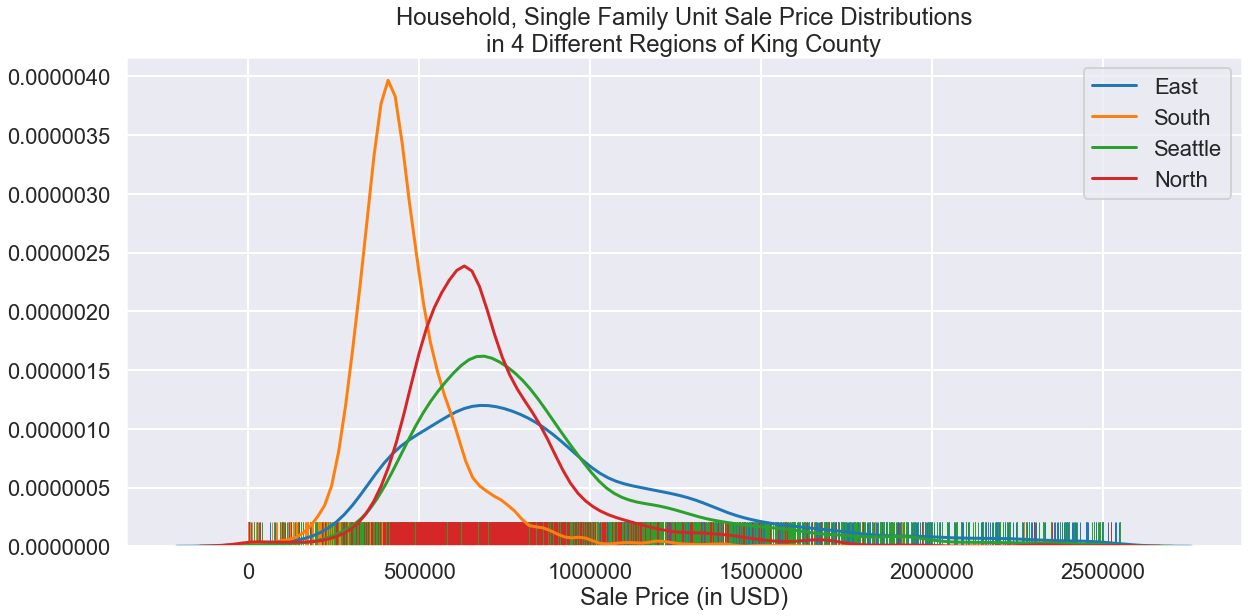

In [89]:
sns.set_context("poster")
sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=(20,9))

sns.distplot(df_7_east.SalePrice, ax=ax, label='East', hist=False, rug=True)
sns.distplot(df_7_south.SalePrice, ax=ax, label=f'South', hist=False, rug=True)
sns.distplot(df_7_seattle.SalePrice, ax=ax, label=f'Seattle', hist=False, rug=True)
sns.distplot(df_7_north.SalePrice, ax=ax, label=f'North', hist=False, rug=True)
ax.legend()
ax.set(title='Household, Single Family Unit Sale Price Distributions\nin 4 Different Regions of King County',
       xlabel='Sale Price (in USD)')
plt.savefig("./../../reports/figures/plt-01.png", bbox_inches='tight')
fig.show();

There are a few things that I notice looking at the above Sale Price distributions plot of 4 different regions (East, South, Seattle, and North):
- **East**, **Seattle**, and **North** are overlapping each other more than **South** does.
- **South** Sale Price seems to have a smaller mean, smaller standard deviation, yet at very high density compared to other regions.

In [90]:
df_7_raw.groupby('Region').SalePrice.agg(['mean',
                                          'min',
                                          'max',
                                          'std',
                                          'count'])

,mean,min,max,std,count
Region,,,,,
East,888648.458585,10,2550000,439105.889470,6459
North,703735.623619,1500,2525000,255857.042358,1177
Seattle,839081.212582,17500,2550000,369350.370846,5325
South,467453.242382,10,2490850,176133.404758,5054


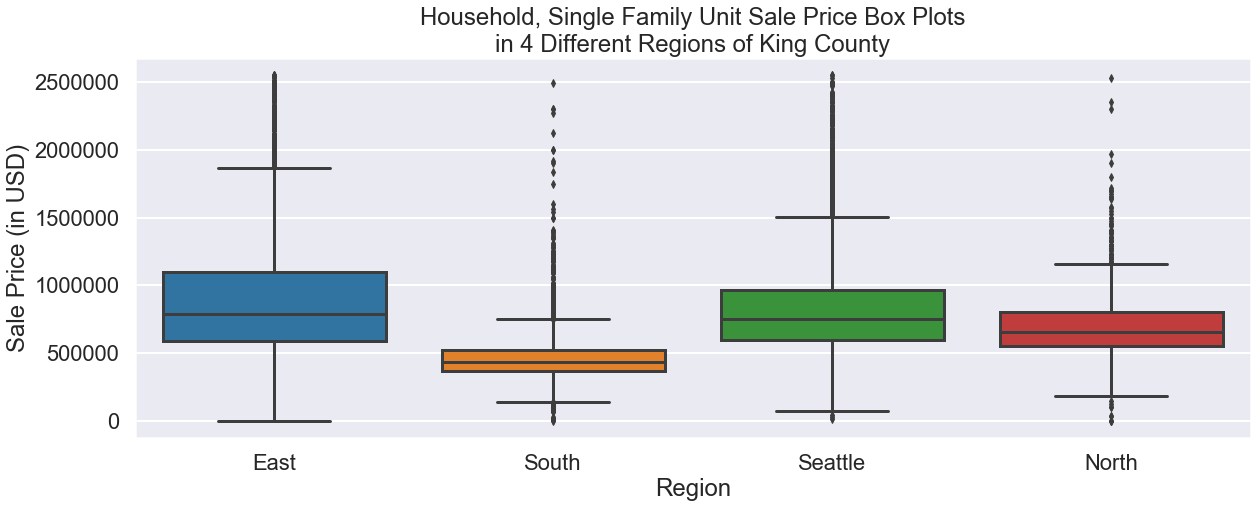

In [91]:
# Visualizae Sale Price using Box Plots
sns.set_context("poster")
sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=(20,7))
sns.boxplot(x='Region', y='SalePrice', data=df_7_raw)

ax.set(title='Household, Single Family Unit Sale Price Box Plots\nin 4 Different Regions of King County',
       ylabel='Sale Price (in USD)')
plt.savefig("./../../reports/figures/plt-02.png", bbox_inches='tight')

fig.show();

Regionalized model results combined with above visualizations have confirmed that these 4 different regions have different Sale Price distributions with different dominant features. Therefore, homeowners in different regions might need to invest in different types of home improvement projects in order to increase their properties' values.

### Renovation

First, I will look at the benefits of doing a renovation and investing in a home improvement project itself.

In [92]:
# East
find_features("Renovated", model_7_east_stepwise.params)

been_Renovated_1    186493.650726
dtype: float64

In [93]:
# South
find_features("Renovated", model_7_south_stepwise.params)

been_Renovated_1    88519.986429
dtype: float64

In [94]:
# Seattle
find_features("Renovated", model_7_seattle_stepwise.params)

Series([], dtype: float64)

In [95]:
# North
find_features("Renovated", model_7_north_stepwise.params)

been_Renovated_1    131178.994186
dtype: float64

These coefficients for `been_Renovated_1` (indicating that a property has been renovated at least once) are all positive and was selected as one of the statistically significant features in 3 out of 4 regions (East, South, and North). It can be interpreted from these coefficients that the fact that a property's renovation has been documented could potentially increase its value by an amount between USD 88519 to USD 186493 depending on the location region. 

Therefore, it seems like we can say that it's worth investing in home improvement projects/renovations to potentially increase a property's value.

In [96]:
renovated = df_7_raw[df_7_raw.been_Renovated == 1].SalePrice
not_renovated = df_7_raw[df_7_raw.been_Renovated == 0].SalePrice

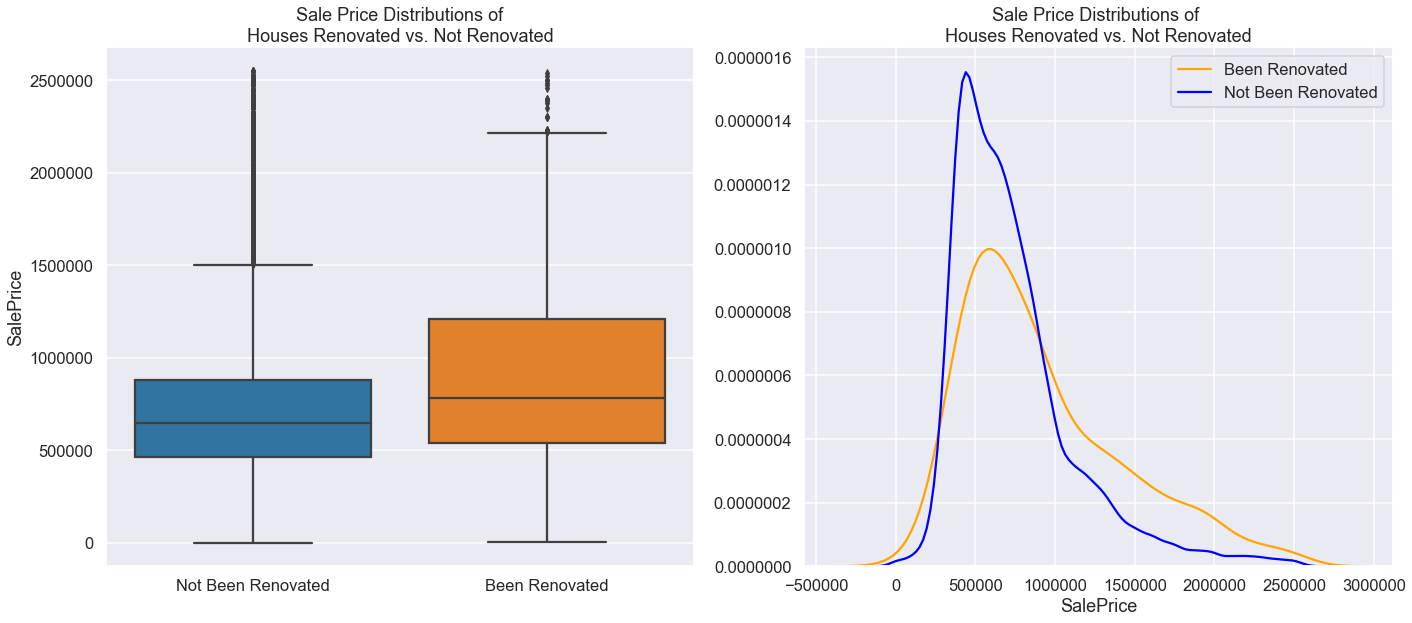

In [141]:
sns.set_context("talk")
sns.set_style("darkgrid")

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,9))

# boxplot
g = sns.boxplot(x='been_Renovated', y='SalePrice', data=df_7_raw, ax=ax1)

# re-label x axis ticks
g.set_xticks(range(2))
g.set_xticklabels(['Not Been Renovated','Been Renovated'])

ax1.set(title='Sale Price Distributions of\nHouses Renovated vs. Not Renovated',
        xlabel='')

# distplot
sns.distplot(renovated, ax=ax2, 
             color='orange', label='Been Renovated', hist=False)
sns.distplot(not_renovated, ax=ax2, 
             color='blue', label='Not Been Renovated', hist=False)

ax2.legend()
ax2.set_title('Sale Price Distributions of \nHouses Renovated vs. Not Renovated')
fig.tight_layout()
plt.savefig("./../../reports/figures/plt-03.png", bbox_inches='tight')

fig.show();

#### T-test

Next, I'll examine this Hypotheses one more time using Welch's T-test:

- **Null Hypothesis (H_0)**: There is no difference in average Sale Price between houses that have been renovated and those that have not.
- **Alternative Hypothesis (H_A)**: The average Sale Price of houses that have been renovated is greater than the average Sale Price of those that have not.

In [98]:
test = stats.ttest_ind(renovated, not_renovated, equal_var=False)

In [99]:
# Print out test results
status = ['Been Renovated', 'Not Been Renovated']

print('\t\tStatistic \t\tp-value')
print(f'Renovation: \t{test.statistic} \t{test.pvalue/2}')

		Statistic 		p-value
Renovation: 	10.621495637052892 	3.3466331975215857e-25


Using a significance level alpha of 0.05, this p-value of 3.3466331975215857e-25 is small enough (< alpha) to reject the Null Hypothesis, meaning there's enough evidence to conclude that investing in renovation and/or home improvement projects could increase market value of a property.

### Porch (Enclosed and Open)

One of the things that I have noticed from the list of features and their coefficients inf 4 different regions is that Porch related features do make appearance.

In [100]:
# East
find_features("Porch", model_7_east_stepwise.params)

has_OpenPorch_1    21960.332911
dtype: float64

In [101]:
# South
find_features("Porch", model_7_south_stepwise.params)

has_OpenPorch_1    13083.558687
dtype: float64

In [102]:
# Seattle
find_features("Porch", model_7_seattle_stepwise.params)

has_OpenPorch_1        24509.02431
has_EnclosedPorch_1   -38562.34762
dtype: float64

In [103]:
# North
find_features("Porch", model_7_north_stepwise.params)

has_EnclosedPorch_1    138693.658964
dtype: float64

- Interestingly, **`has_OpenPorch_1`** (indicating the property does have an open porch) appeared in 3 out of 4 regions' selected features (using stepwise selection). They all have positive coefficients, which indicates that as the value of `has_OpenPorch_1` goes up (0 to 1 from `has_OpenPorch_0` to `has_OpenPorch_1`), the dependent variable `SalePrice` also tends to go up, while keeping all the other predictors constant (selected predictors do vary among different regions).

- On the other hand, **`has_EnclosedPorch_1`** is selected in the Seattle and North areas, and actually has a negative coefficient in Seattle. This indicates that in Seattle, while keeping all other features constant, having an Enclosed Porch and Sale Price somehow go in opposite direction.

Overall, Open Porch seems to be a better choice for home improvement project in King County. Depending on the property's location, especially in the East, South, and Seattle area, estimated increase in value by adding an Open Porch does vary between USD 13083 to USD 24509. However, if the property is in the North region, it might be more beneficial to invest in an Enclosed Porch, which is estimated to increase the Sale Price by USD 138693 there.

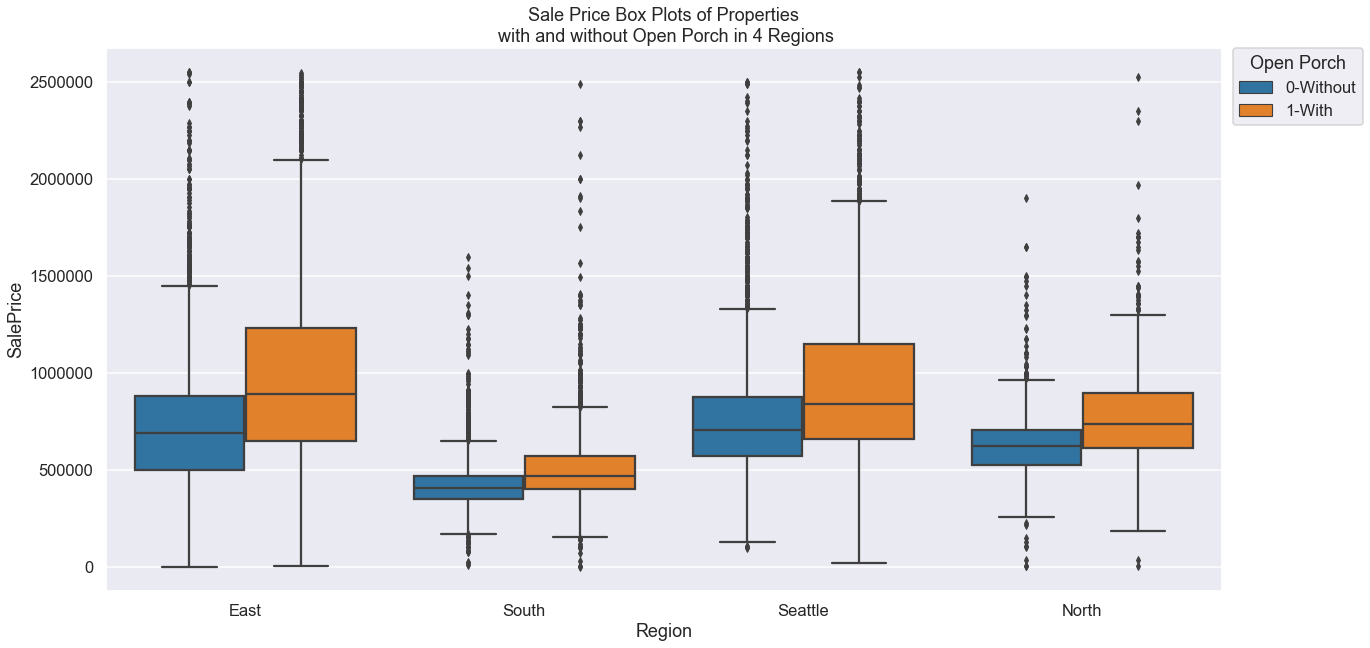

In [104]:
sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=(20,10))
g = sns.boxplot(x='Region', y='SalePrice', hue='has_OpenPorch', data=df_7_raw)
ax.set(title='Sale Price Box Plots of Properties\n with and without Open Porch in 4 Regions')

# move legend to outside the plot
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

# rename legend title & labels
leg = g.axes.get_legend()
new_title = 'Open Porch'
leg.set_title(new_title)
new_labels = ['0-Without', '1-With']
for t, l in zip(leg.texts, new_labels): t.set_text(l)
    
plt.savefig("./../../reports/figures/plt-04.png", bbox_inches='tight')        
fig.show();

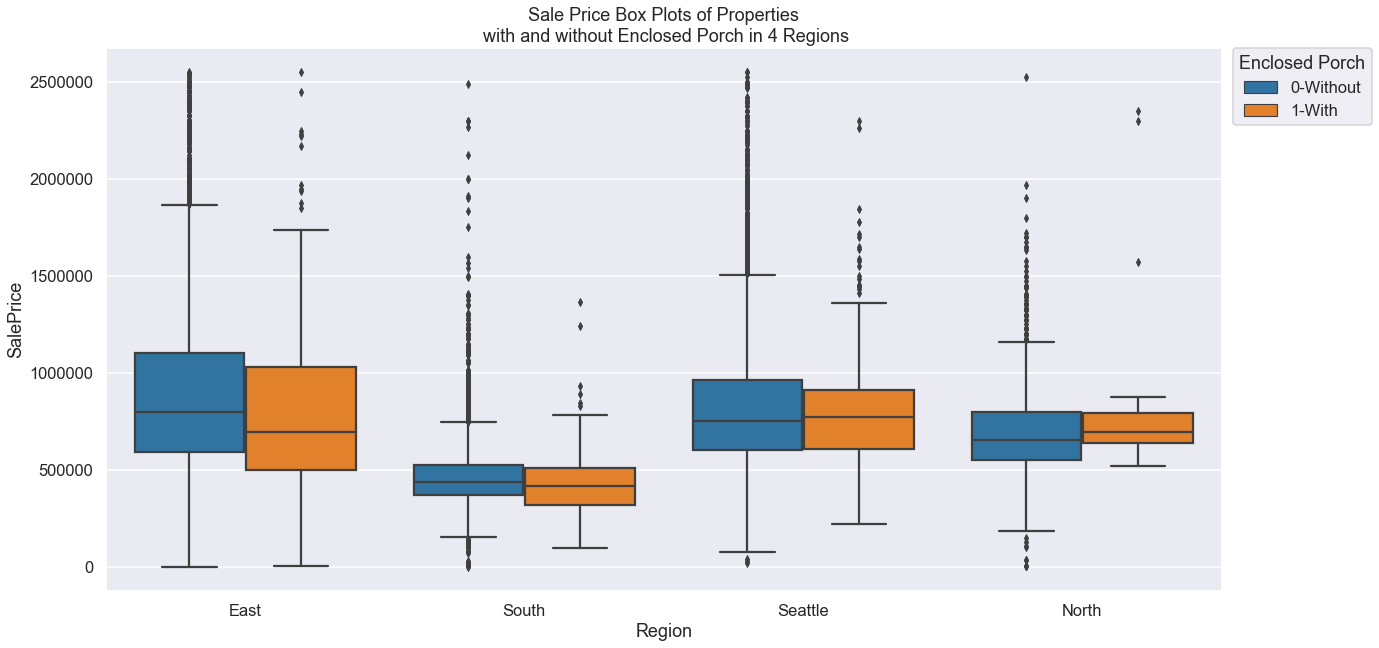

In [105]:
sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=(20,10))
g = sns.boxplot(x='Region', y='SalePrice', hue='has_EnclosedPorch', data=df_7_raw)
ax.set(title='Sale Price Box Plots of Properties\n with and without Enclosed Porch in 4 Regions')

# move legend to outside the plot
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

# rename legend title & labels
leg = g.axes.get_legend()
new_title = 'Enclosed Porch'
leg.set_title(new_title)
new_labels = ['0-Without', '1-With']
for t, l in zip(leg.texts, new_labels): t.set_text(l)
    
plt.savefig("./../../reports/figures/plt-05.png", bbox_inches='tight')
fig.show();

#### T-tests

I will also perform t-tests on these samples to examine above Hypotheses in 4 regions.

1. **Open Porch**

- **Null Hypothesis (H_0)**: There is no difference in average Sale Price between houses with and without an open porch.
- **Alternative Hypothesis (H_A)**: The average Sale Price of houses with an Open Porch is greater than the average Sale Price of those without one.

In [106]:
# Obtain SalePrice array for each region's properties
# separated by whether they have Open Porch or not

open_porch_east, no_open_porch_east = separate(df_7_raw[df_7_raw.Region=='East'], 
                                               'has_OpenPorch', 'SalePrice')
open_porch_south, no_open_porch_south = separate(df_7_raw[df_7_raw.Region=='South'], 
                                                 'has_OpenPorch', 'SalePrice')
open_porch_seattle, no_open_porch_seattle = separate(df_7_raw[df_7_raw.Region=='Seattle'], 
                                                     'has_OpenPorch', 'SalePrice')
open_porch_north, no_open_porch_north = separate(df_7_raw[df_7_raw.Region=='North'], 
                                                 'has_OpenPorch', 'SalePrice')

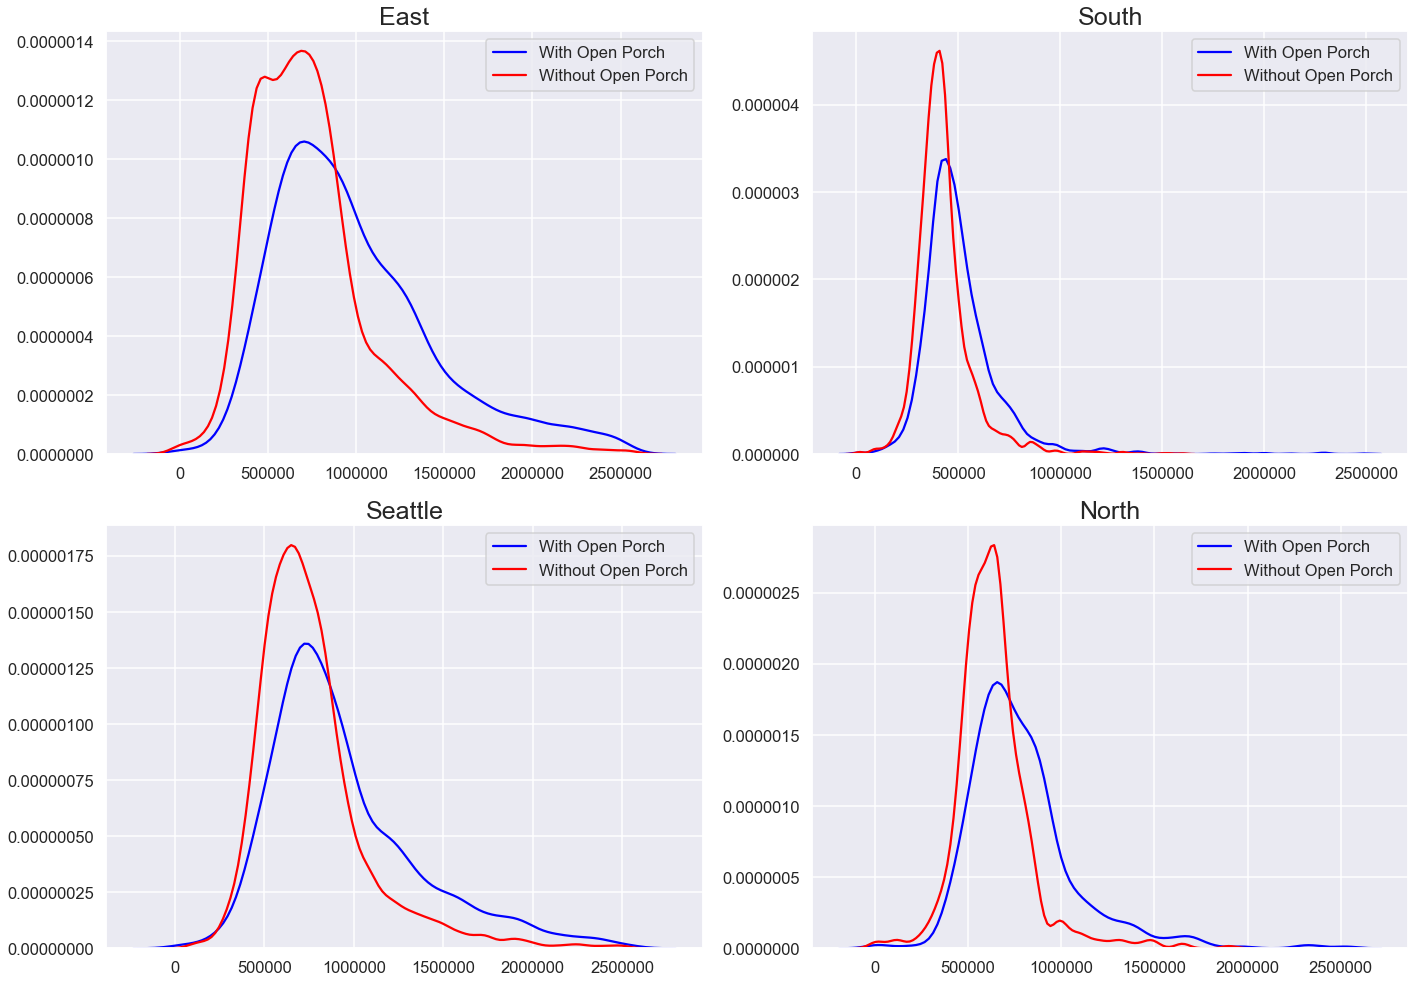

In [107]:
# Visualize
sns.set_context("talk")
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,14))

# East
ax1 = axes[0][0]
sns.distplot(open_porch_east, ax=ax1, color='blue', label='With Open Porch', hist=False)
sns.distplot(no_open_porch_east, ax=ax1, color='red', label='Without Open Porch', hist=False)
ax1.set_title('East', fontsize=25)
ax1.legend()

# South
ax2 = axes[0][1]
sns.distplot(open_porch_south, ax=ax2, color='blue', label='With Open Porch', hist=False)
sns.distplot(no_open_porch_south, ax=ax2, color='red', label='Without Open Porch', hist=False)
ax2.set_title('South', fontsize=25)
ax2.legend()

# Seattle
ax3 = axes[1][0]
sns.distplot(open_porch_seattle, ax=ax3, color='blue', label='With Open Porch', hist=False)
sns.distplot(no_open_porch_seattle, ax=ax3, color='red', label='Without Open Porch', hist=False)
ax3.set_title('Seattle', fontsize=25)
ax3.legend()

# Seattle
ax4 = axes[1][1]
sns.distplot(open_porch_north, ax=ax4, color='blue', label='With Open Porch', hist=False)
sns.distplot(no_open_porch_north, ax=ax4, color='red', label='Without Open Porch', hist=False)
ax4.set_title('North', fontsize=25)
ax4.legend()

fig.tight_layout()
plt.savefig("./../../reports/figures/plt-06.png", bbox_inches='tight')
fig.show();

Run Welch's T-test on these `SalePrice` arrays:

In [108]:
test_east = stats.ttest_ind(open_porch_east, no_open_porch_east, equal_var=False)
test_south = stats.ttest_ind(open_porch_south, no_open_porch_south, equal_var=False)
test_seattle = stats.ttest_ind(open_porch_seattle, no_open_porch_seattle, equal_var=False)
test_north = stats.ttest_ind(open_porch_north, no_open_porch_north, equal_var=False)

In [109]:
# Print out test results
tests = [test_east, test_south, test_seattle, test_north]
regions = ['East', 'South', 'Seattle', 'North']

print('\t\tStatistic \t\tp-value')
print()
for idx, t in enumerate(tests):
    print(f'{regions[idx]:8} \t{t.statistic} \t{t.pvalue/2}')

		Statistic 		p-value

East     	23.697719708308963 	2.1766514318008032e-119
South    	16.710309524516386 	3.5567878160110106e-61
Seattle  	17.00654518716977 	7.176599801766623e-63
North    	10.276628539327355 	8.517591634558851e-24


Using a significance level alpha of 0.05, the p-values for all 4 tests are smaller than alpha, which means we have enough evidence to **Reject the Null Hypothesis** 

--> The average Sale Price of houses with an Open Porch is greater than the average Sale Price of those without one in all 4 regions.

2. **Enclosed Porch**

    Next I am going to repeat the same process with Enclosed Porch:

- **Null Hypothesis (H_0)**: There is no difference in average Sale Price between houses with and without an enclosed porch.
- **Alternative Hypothesis (H_A)**: The average Sale Price of houses with an enclosed porch is greater than the average Sale Price of those without one.

In [110]:
# Obtain SalePrice array for each region's properties
# separated by whether they have Open Porch or not

enclosed_porch_east, no_enclosed_porch_east = separate(df_7_raw[df_7_raw.Region=='East'], 
                                               'has_EnclosedPorch', 'SalePrice')
enclosed_porch_south, no_enclosed_porch_south = separate(df_7_raw[df_7_raw.Region=='South'], 
                                                 'has_EnclosedPorch', 'SalePrice')
enclosed_porch_seattle, no_enclosed_porch_seattle = separate(df_7_raw[df_7_raw.Region=='Seattle'], 
                                                     'has_EnclosedPorch', 'SalePrice')
enclosed_porch_north, no_enclosed_porch_north = separate(df_7_raw[df_7_raw.Region=='North'], 
                                                 'has_EnclosedPorch', 'SalePrice')

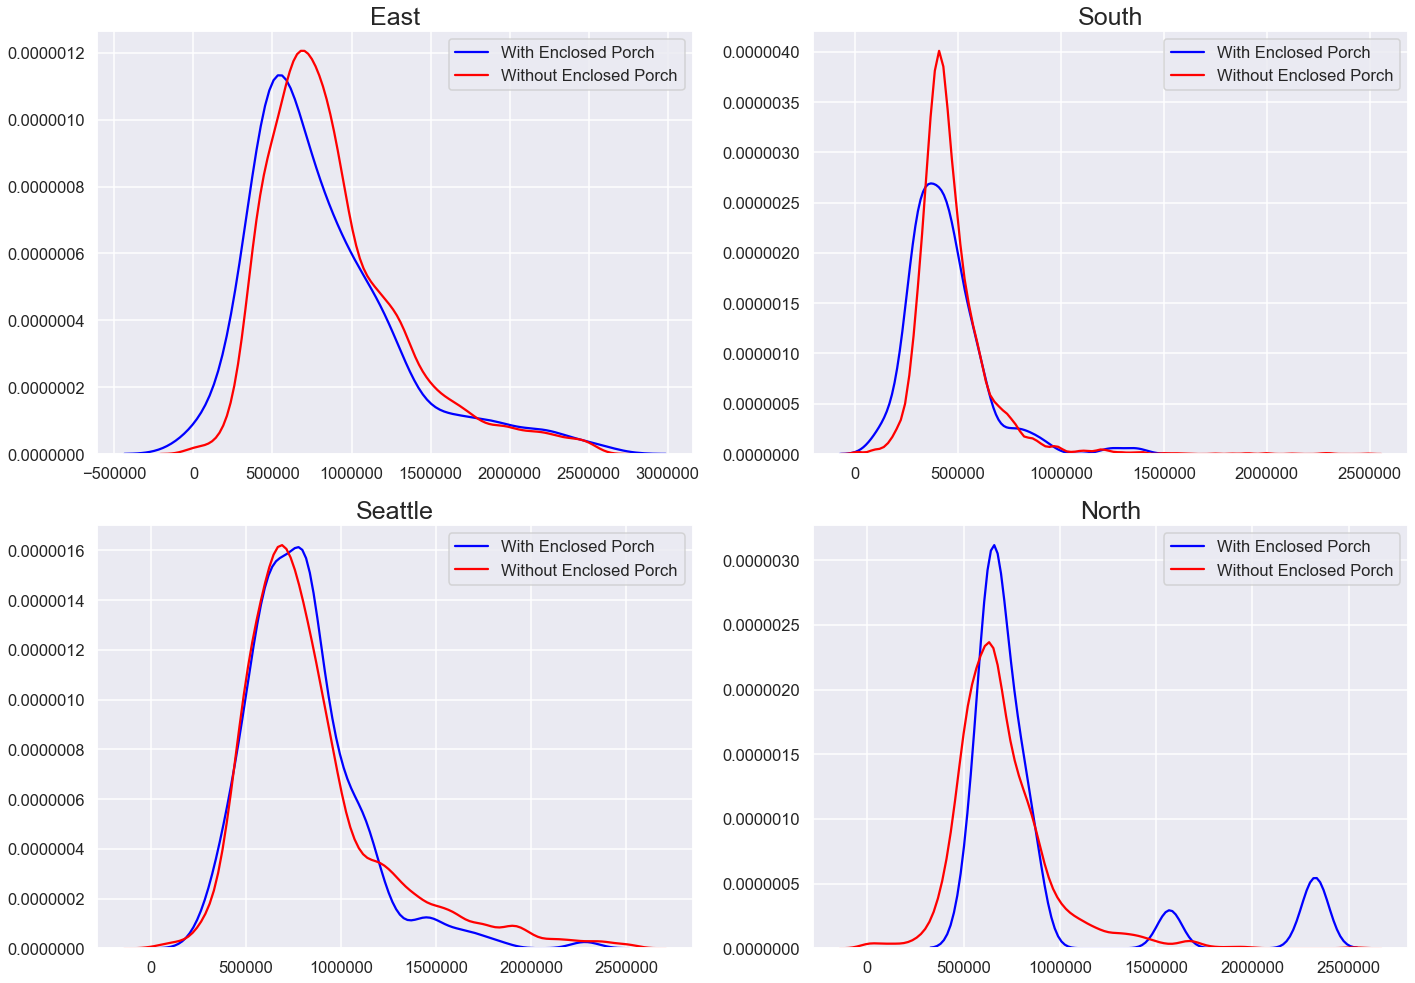

In [111]:
# Visualize
sns.set_context("talk")

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,14))

# East
ax1 = axes[0][0]
sns.distplot(enclosed_porch_east, ax=ax1, color='blue', label='With Enclosed Porch', hist=False)
sns.distplot(no_enclosed_porch_east, ax=ax1, color='red', label='Without Enclosed Porch', hist=False)
ax1.set_title('East', fontsize=25)
ax1.legend()


# South
ax2 = axes[0][1]
sns.distplot(enclosed_porch_south, ax=ax2, color='blue', label='With Enclosed Porch', hist=False)
sns.distplot(no_enclosed_porch_south, ax=ax2, color='red', label='Without Enclosed Porch', hist=False)
ax2.set_title('South', fontsize=25)
ax2.legend()

# Seattle
ax3 = axes[1][0]
sns.distplot(enclosed_porch_seattle, ax=ax3, color='blue', label='With Enclosed Porch', hist=False)
sns.distplot(no_enclosed_porch_seattle, ax=ax3, color='red', label='Without Enclosed Porch', hist=False)
ax3.set_title('Seattle', fontsize=25)
ax3.legend()

# Seattle
ax4 = axes[1][1]
sns.distplot(enclosed_porch_north, ax=ax4, color='blue', label='With Enclosed Porch', hist=False)
sns.distplot(no_enclosed_porch_north, ax=ax4, color='red', label='Without Enclosed Porch', hist=False)
ax4.set_title('North', fontsize=25)
ax4.legend()

fig.tight_layout()
plt.savefig("./../../reports/figures/plt-07.png", bbox_inches='tight')
fig.show();

In [112]:
test_east = stats.ttest_ind(enclosed_porch_east, no_enclosed_porch_east, equal_var=False)
test_south = stats.ttest_ind(enclosed_porch_south, no_enclosed_porch_south, equal_var=False)
test_seattle = stats.ttest_ind(enclosed_porch_seattle, no_enclosed_porch_seattle, equal_var=False)
test_north = stats.ttest_ind(enclosed_porch_north, no_enclosed_porch_north, equal_var=False)

In [113]:
# Print out test results
tests = [test_east, test_south, test_seattle, test_north]
regions = ['East', 'South', 'Seattle', 'North']

print('\t\tStatistic \t\tp-value')
print()
for idx, t in enumerate(tests):
    print(f'{regions[idx]:8} \t{t.statistic} \t{t.pvalue/2}')

		Statistic 		p-value

East     	-2.0590176599286103 	0.020405372452203124
South    	-1.8382398088072762 	0.03405914444874473
Seattle  	-3.4881459804463884 	0.0002623701095984924
North    	1.6113868210371423 	0.06131984299755977


Among 4 regions, North is the only one with a p-value greater than alpha (0.05), which means there's not enough evidence to reject the Null Hypothesis in the northern part of King County. 

Although the other 3 regions do have p-values smaller than alpha of 0.05, they're still much greater than p-values for Open Porch. 

These t-test results as well as visualizations do confirm the above findings using Linear Regression Coefficients above.

### Heat System

First, I will look at the cofficients for all heat-related features in regionalized models.

In [114]:
# East
find_features("Heat", model_7_east_stepwise.params)

HeatSystem_HotWater       142063.398479
HeatSource_Electricity    -52289.269817
HeatSystem_ForcedAir      -33246.446591
dtype: float64

In [115]:
# South
find_features("Heat", model_7_south_stepwise.params)

HeatSystem_HeatPump    72183.967173
HeatSource_Oil         47855.282018
HeatSystem_HotWater    52957.971219
dtype: float64

In [116]:
# Seattle
find_features("Heat", model_7_seattle_stepwise.params)

HeatSystem_HeatPump       54509.069104
HeatSource_Electricity   -36065.697213
dtype: float64

In [117]:
# North
find_features("Heat", model_7_north_stepwise.params)

HeatSource_Oil    52164.369115
dtype: float64

Looking at the coefficients for `HeatSystem` feature, I can identify some of the more financially beneficial for homeowners in based on their location regions are as follows:
- Hot Water seems to be the best option in the East region 
- Heat Pump seems to be the top choice for properties in the South and Seattle regions
- No specific type of Heat System was selected as predictors in the North

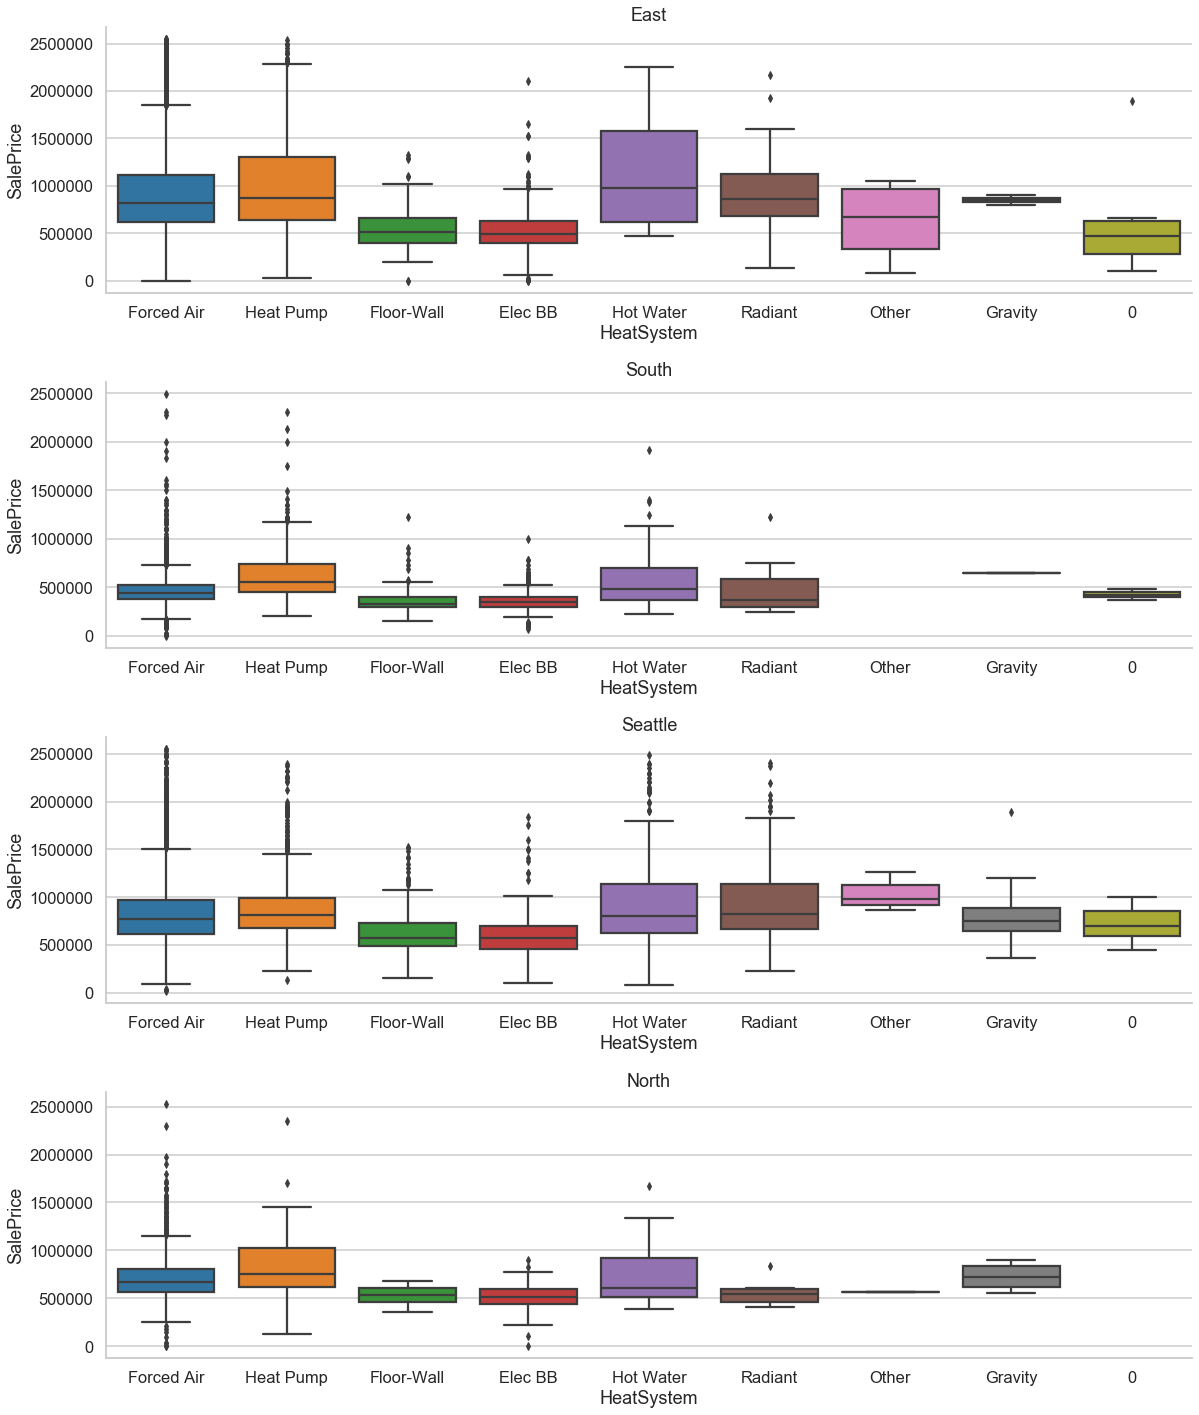

In [118]:
sns.set_context("talk")
sns.set_style('whitegrid')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=1, nrows=4, figsize=(17,20))
order = ['Forced Air', 'Heat Pump', 'Floor-Wall', 'Elec BB', 'Hot Water', 
         'Radiant', 'Other', 'Gravity', '0']

# East
sns.boxplot(x='HeatSystem', y='SalePrice', data=df_7_raw[df_7_raw.Region=='East'], 
            ax=ax1, order=order)
ax1.set(title='East')

# South
sns.boxplot(x='HeatSystem', y='SalePrice', data=df_7_raw[df_7_raw.Region=='South'], 
            ax=ax2, order=order)
ax2.set(title='South')

# Seattle
sns.boxplot(x='HeatSystem', y='SalePrice', data=df_7_raw[df_7_raw.Region=='Seattle'], 
            ax=ax3, order=order)
ax3.set(title='Seattle')

# North
sns.boxplot(x='HeatSystem', y='SalePrice', data=df_7_raw[df_7_raw.Region=='North'], 
            ax=ax4, order=order)
ax4.set(title='North')

fig.tight_layout()
sns.despine()
plt.savefig("./../../reports/figures/plt-08.png", bbox_inches='tight')
fig.show();

In [119]:
region_dfs = [df_7_east, df_7_south, df_7_seattle, df_7_north]
regions = ['East', 'South', 'Seattle', 'North']
heatsys = ['ForcedAir', 'HeatPump', 'HotWater']
region_heatsys = {'East': {}, 'South': {}, 'Seattle': {}, 'North': {}}
for i, region_df in enumerate(region_dfs):
    for sys in heatsys:
        region_heatsys[regions[i]][sys] = region_df[region_df[f'HeatSystem_{sys}']==1].SalePrice

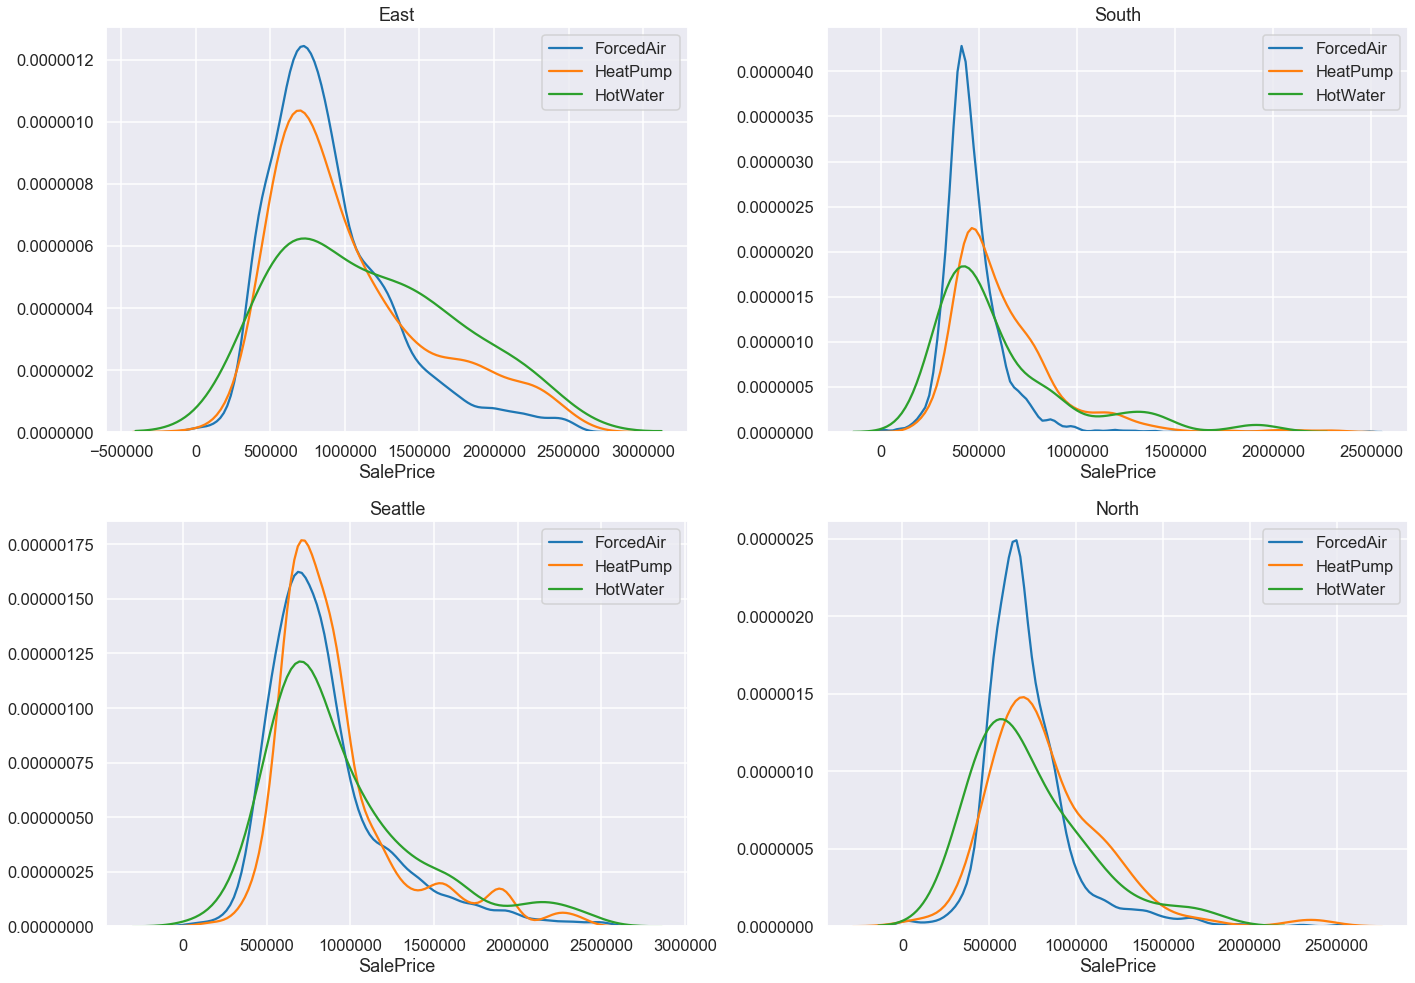

In [120]:
# Visualize
sns.set_context("talk")
sns.set_style('darkgrid')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,14))

for idx, region in enumerate(region_heatsys.keys()):
    ax = axes[idx // 2][idx % 2]
    for sys in region_heatsys[region].keys():
        sns.distplot(region_heatsys[region][sys], ax=ax, label=f'{sys}', hist=False)
    ax.set_title(f'{region}')
    ax.legend()

fig.tight_layout()
plt.savefig("./../../reports/figures/plt-09.png", bbox_inches='tight')

fig.show();

These plots: 
- show that **Forced Air** may be the most popular choices for homowners in King County (overall denstity of `ForcedAir` is higher than that of other systems)
- confirm my findings using Linear Regression models in the above that:
    - **Hot Water** seems to be the best option in the **East** region 
    - **Heat Pump** seems to be the top choice for properties in the **South** and **Seattle** regions
- also provide some more information on the type of Heat System options for homeowners in the Northern region:
    - **Heat Pump** or **Hot Water** would probably add more value to a property in the **North** region 

### Deck

In [121]:
# East
find_features("Deck", model_7_east_stepwise.params)

Series([], dtype: float64)

In [122]:
# South
find_features("Deck", model_7_south_stepwise.params)

has_Deck_1    11938.616296
dtype: float64

In [123]:
# Seattle
find_features("Deck", model_7_seattle_stepwise.params)

has_Deck_1    21772.935432
dtype: float64

In [124]:
# North
find_features("Deck", model_7_north_stepwise.params)

Series([], dtype: float64)

Based on the coefficients for `has_Deck` in the 4 models, including a deck seems to help increase the value of a property in the South and Seattle regions by approximately USD 11938 and USD 21772 respectively. There's not enough evidence from my Linear Regression models to make any conclusion on the impact of a deck on properties in the other 2 regions (East and North).

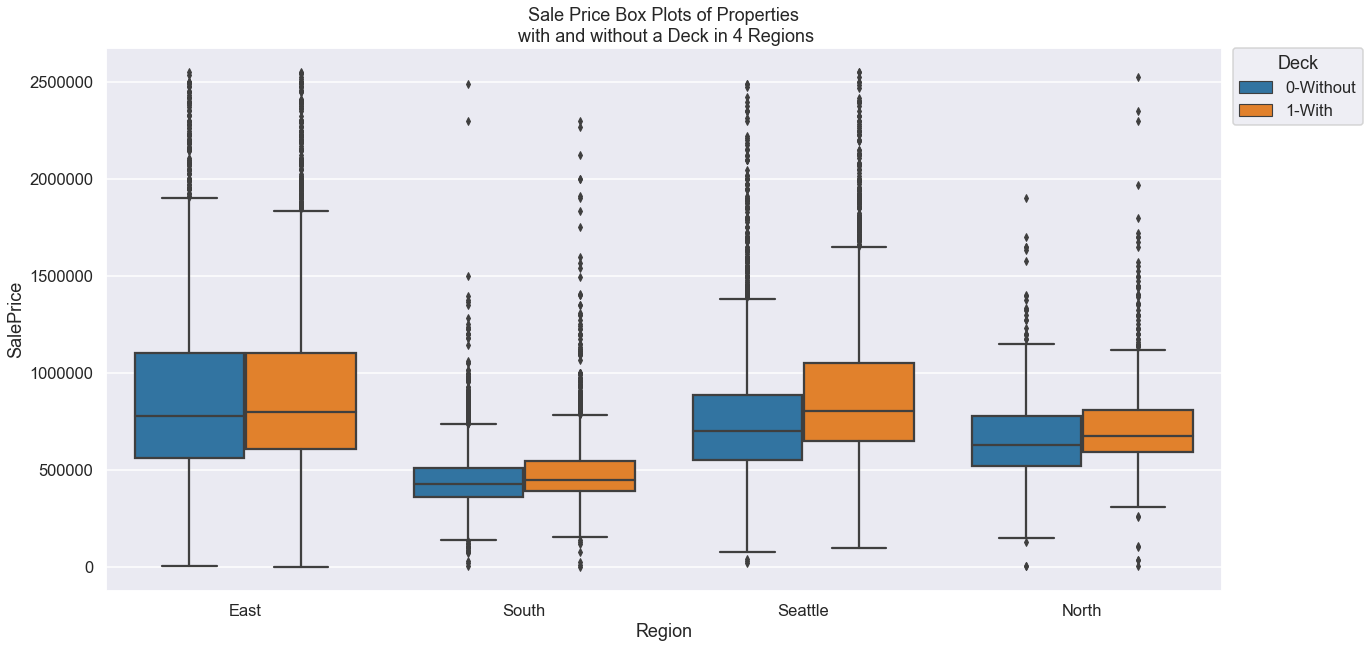

In [125]:
sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=(20,10))
g = sns.boxplot(x='Region', y='SalePrice', hue='has_Deck', data=df_7_raw);
ax.set(title='Sale Price Box Plots of Properties\n with and without a Deck in 4 Regions')

# move legend to outside the plot
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

# rename legend title & labels
leg = g.axes.get_legend()
new_title = 'Deck'
leg.set_title(new_title)
new_labels = ['0-Without', '1-With']
for t, l in zip(leg.texts, new_labels): t.set_text(l)
    
plt.savefig("./../../reports/figures/plt-10.png", bbox_inches='tight')
fig.show();

This plot is also in line with my observations based on the coefficients above. Although, we can also perform Welch's t-test on all 4 regions to see if it would also be beneficial in the other the East and the North as well.

#### T-test

In [126]:
# Obtain SalePrice array for each region's properties
# separated by whether they have a Deck or not

deck_east, no_deck_east = separate(df_7_raw[df_7_raw.Region=='East'], 
                                   'has_Deck', 'SalePrice')
deck_south, no_deck_south = separate(df_7_raw[df_7_raw.Region=='South'], 
                                   'has_Deck', 'SalePrice')
deck_north, no_deck_north = separate(df_7_raw[df_7_raw.Region=='North'], 
                                   'has_Deck', 'SalePrice')
deck_seattle, no_deck_seattle = separate(df_7_raw[df_7_raw.Region=='Seattle'], 
                                   'has_Deck', 'SalePrice')

In [127]:
test_east = stats.ttest_ind(deck_east, no_deck_east, equal_var=False)
test_south = stats.ttest_ind(deck_south, no_deck_south, equal_var=False)
test_seattle = stats.ttest_ind(deck_seattle, no_deck_seattle, equal_var=False)
test_north = stats.ttest_ind(deck_north, no_deck_north, equal_var=False)

In [128]:
# Print out test results
tests = [test_east, test_south, test_seattle, test_north]
regions = ['East', 'South', 'Seattle', 'North']

print('\t\tStatistic \t\tp-value')
print()
for idx, t in enumerate(tests):
    print(f'{regions[idx]:8} \t{t.statistic} \t{t.pvalue/2}')

		Statistic 		p-value

East     	3.255043923497328 	0.0005698072860609541
South    	7.892814260611681 	1.957348893194061e-15
Seattle  	13.959401555560355 	8.350539993122852e-44
North    	4.555179093551201 	2.8917403537192008e-06


All 4 p-values are smaller than significance level (0.05), which means we can Reject the Null Hypothesis in all 4 Regions.

Therefore, we can conclude that investing in a Deck would be one of the options that home-owners in King County can consider in order to increase market value of their properties.

### Bedrooms

In [129]:
# East
find_features("Bed", model_7_east_stepwise.params)

Bedrooms_4   -29929.518950
Bedrooms_2    57220.046372
dtype: float64

In [130]:
# south
find_features("Bed", model_7_south_stepwise.params)

Bedrooms_1    138353.756983
Bedrooms_6    -48971.410646
dtype: float64

In [131]:
# seattle
find_features("Bed", model_7_seattle_stepwise.params)

Bedrooms_1    156346.188857
Bedrooms_6   -115300.584653
Bedrooms_9   -683086.989126
dtype: float64

In [132]:
# north
find_features("Bed", model_7_north_stepwise.params)

Series([], dtype: float64)

In [133]:
# model_4_stepwise
find_features("Bed", model_4_stepwise.params).sort_values(ascending=False)

Bedrooms_1    143115.425173
Bedrooms_3     27458.108473
Bedrooms_2     27408.286476
Bedrooms_6    -68800.299060
Bedrooms_9   -275755.107659
dtype: float64

The overall trend that I can notice from these coefficients is that the sale value of a property only increase as we increase number of bedrooms a certain amount (likely in the 4-5 range), and then it starts going down after. This could also partly be due to the lack of entries for the higher amount of bedrooms as compared to lower ones.

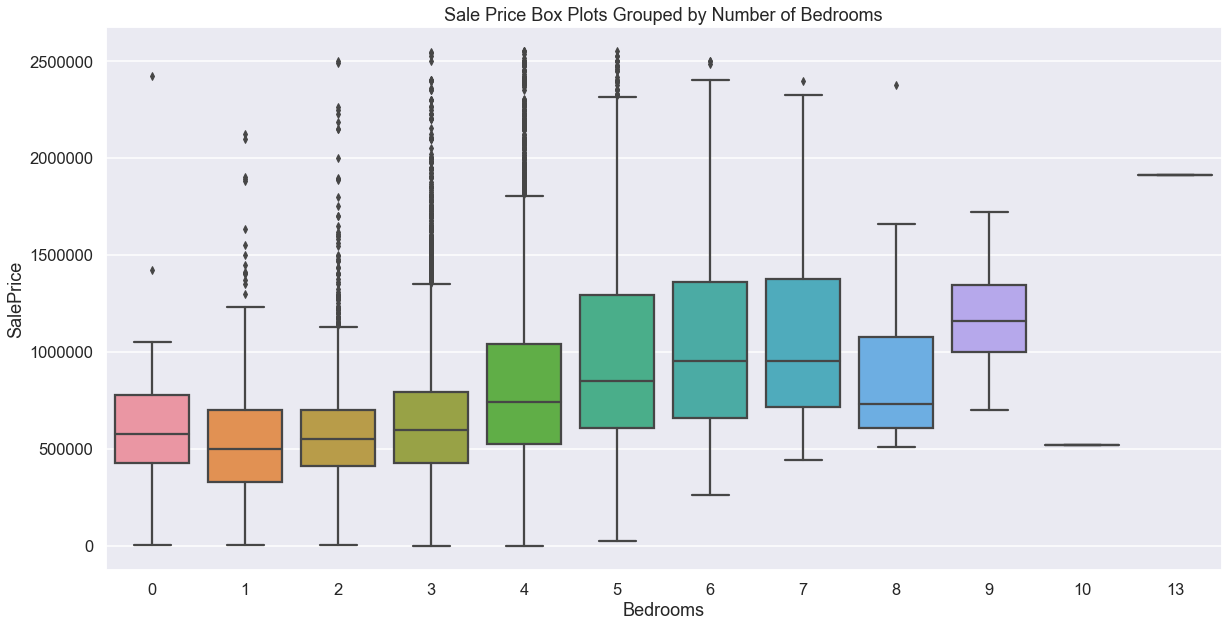

In [134]:
sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(x='Bedrooms', y='SalePrice', data=df_7_raw)
ax.set_title('Sale Price Box Plots Grouped by Number of Bedrooms')
plt.savefig("./../../reports/figures/plt-11.png", bbox_inches='tight')
fig.show();

## Conclusions

Tailoring models based on geographic regions seems to have improved the overall quality and inferential capabilities of my models. Some findings that could be beneficial for home-owners in King County to potentially increase the market value of their properties can be derived from this inferential analysis as follows:

- First and foremost, it is worth investing in a **Renovation** and/or Home Improvement Projects, as houses that have been documented as "been renovated" have a significantly higher sales price than those that have not. This is highly recommended especially for properties in the Eastern, Southern and Northern part of King County, where investing in a renovation can increase sale price by USD 88,000 to USD 186,000.  


- **Porch**:
    - Home-owners in the East, South, and Seattle areas should invest in Open Porch: Estimated increase in value by adding an Open Porch does varies between USD 13,000 to USD 24,000 depending on the specific area. 
    - However, for home-owners in the Northern part of King County, an Enclosed Porch might add more value to the house by approximately USD 138,000.


- **Heat System**:
    - Forced Air may be the most popular choices for homowners in King County, but
    - Hot Water seems to be the best option in the East region (estimated sale price increase of USD 142000) 
    - Heat Pump and Hot Water seems to be the top choices for properties in the South and Seattle regions (estimated sale price increase of USD 52,000 to USD 72,000), and most likely in the North region of King County as well.
    
    
- **Deck**:
    - Houses with Deck have significantly higher average sale price than those that don't. 
    - Including a Deck seems to help increase the value of a property in the South and Seattle regions by approximately USD 11,000 and USD 21,000 respectively.
    
    
- **Bedrooms**: Sale value of a property only increase as we increase number of bedrooms to a certain amount (likely in the 4-5 count range), and then it starts going down after

### Next Steps

- Ideally I would like to explore the impact of different features' interactions on the Sale Price of residential properties in each region of King County; however, due to computational limitations, I was not able to include it in this project at this time.

- In addition, inferential models for this project have been built mainly based on an outliers-removed copy of target variable `SalePrice`. A data transformation/cleaning combination that outperforms this current version of the model has not yet been identified. In addition, some of the thresholds/metrics used to establish models are still arbitrary and worth experimenting with in the future. 